# Import Packages

In [234]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Plot Setup
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

# Import imputed data

In [235]:
df = pd.read_csv('../data/imputed_data.csv')

In [236]:
df.columns

Index(['AirTemp', 'Azimuth', 'CloudOpacity', 'DewpointTemp', 'Dhi', 'Dni',
       'Ebh', 'Ghi', 'GtiFixedTilt', 'GtiTracking', 'PrecipitableWater',
       'RelativeHumidity', 'SurfacePressure', 'Zenith', 'AlbedoDaily', 'Ppv1',
       'PrealL1', 'PrealL2', 'PrealL3', 'EMS_total_load', 'DateTime',
       'Day sin', 'Day cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos',
       'SinZenith', 'SinAzimuth'],
      dtype='object')

In [237]:
date_time = df.DateTime

# Select Features for Load Forecasting

In [238]:
df = df[['PrealL1', 'PrealL2', 'PrealL3', 'EMS_total_load', 'Day sin', 'Day cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos']]

# Split Data

A `(80%, 10%, 10%)` split for the training, validation, and test sets is used. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [239]:
column_indices = {name: i for i, name in enumerate(df.columns)} # Create dictionary containing the feature and the respective index

n = len(df)
train_df = df[0:int(n*0.8)] # Take first 70% of data
val_df = df[int(n*0.8):int(n*0.9)] # Take next 20% of data
test_df = df[int(n*0.9):] # Take last 10% of Data

num_features = df.shape[1] # Number of features (number of columns in df)

# Standardise Data

In [240]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

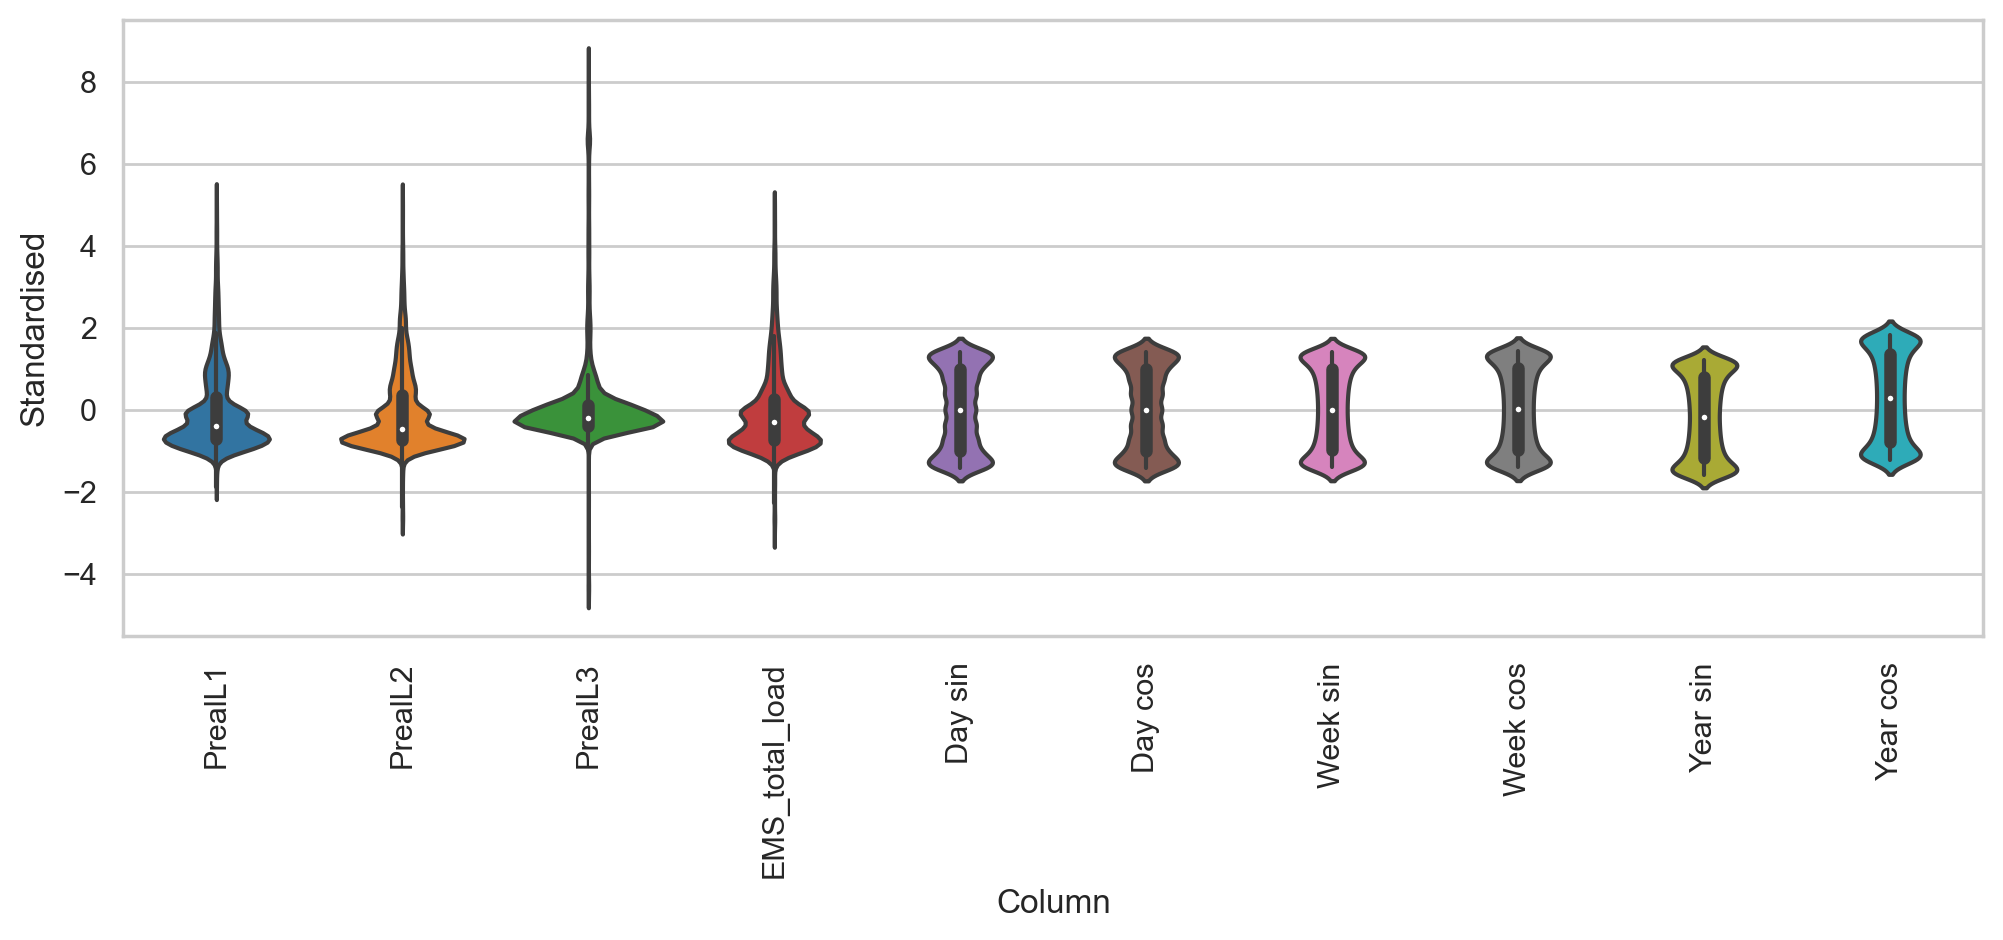

In [319]:
df_std = (df - train_mean) / train_std # Standardise Data
df_std = df_std.melt(var_name='Column', value_name='Standardised') # Add column name as identifier. df_std = [index, Column, Standardised] with num_features x len(df) rows.
plt.figure(figsize=(12, 4))
ax = sns.violinplot(x='Column', y='Standardised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Index and Offsets

In [242]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width) # Slice object = [start, stop, step]
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

This code defines a class named `WindowGenerator` which takes a series of time series data and creates windows of a specified size for use in machine learning models.

The `WindowGenerator` class takes the following parameters in its constructor:

- `input_width`: the number of time steps in the input window.
- `label_width`: the number of time steps in the label window.
- `shift`: the number of time steps by which the input and label windows are shifted.
- `train_df`, `val_df`, and `test_df`: dataframes containing the training, validation, and test data, respectively.
- `label_columns`: a list of columns in the dataframes to be used as the target/label data.
The class has several class variables that store the input data, label columns, and window parameters. It also has several variables that store the indices of the input and label data within the window.

The `__repr__` method returns a string representation of the class, including information about the total window size, the indices of the input and label data, and the label column names.

In [243]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['EMS_total_load'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['EMS_total_load']

In [244]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['EMS_total_load'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['EMS_total_load']

### 2. Split Windows

In [245]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

Try it out:

In [246]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


## 2. Plot

In [247]:
w2.example = example_inputs, example_labels

In [248]:
def plot(self, model=None, plot_col='EMS_total_load', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [std]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

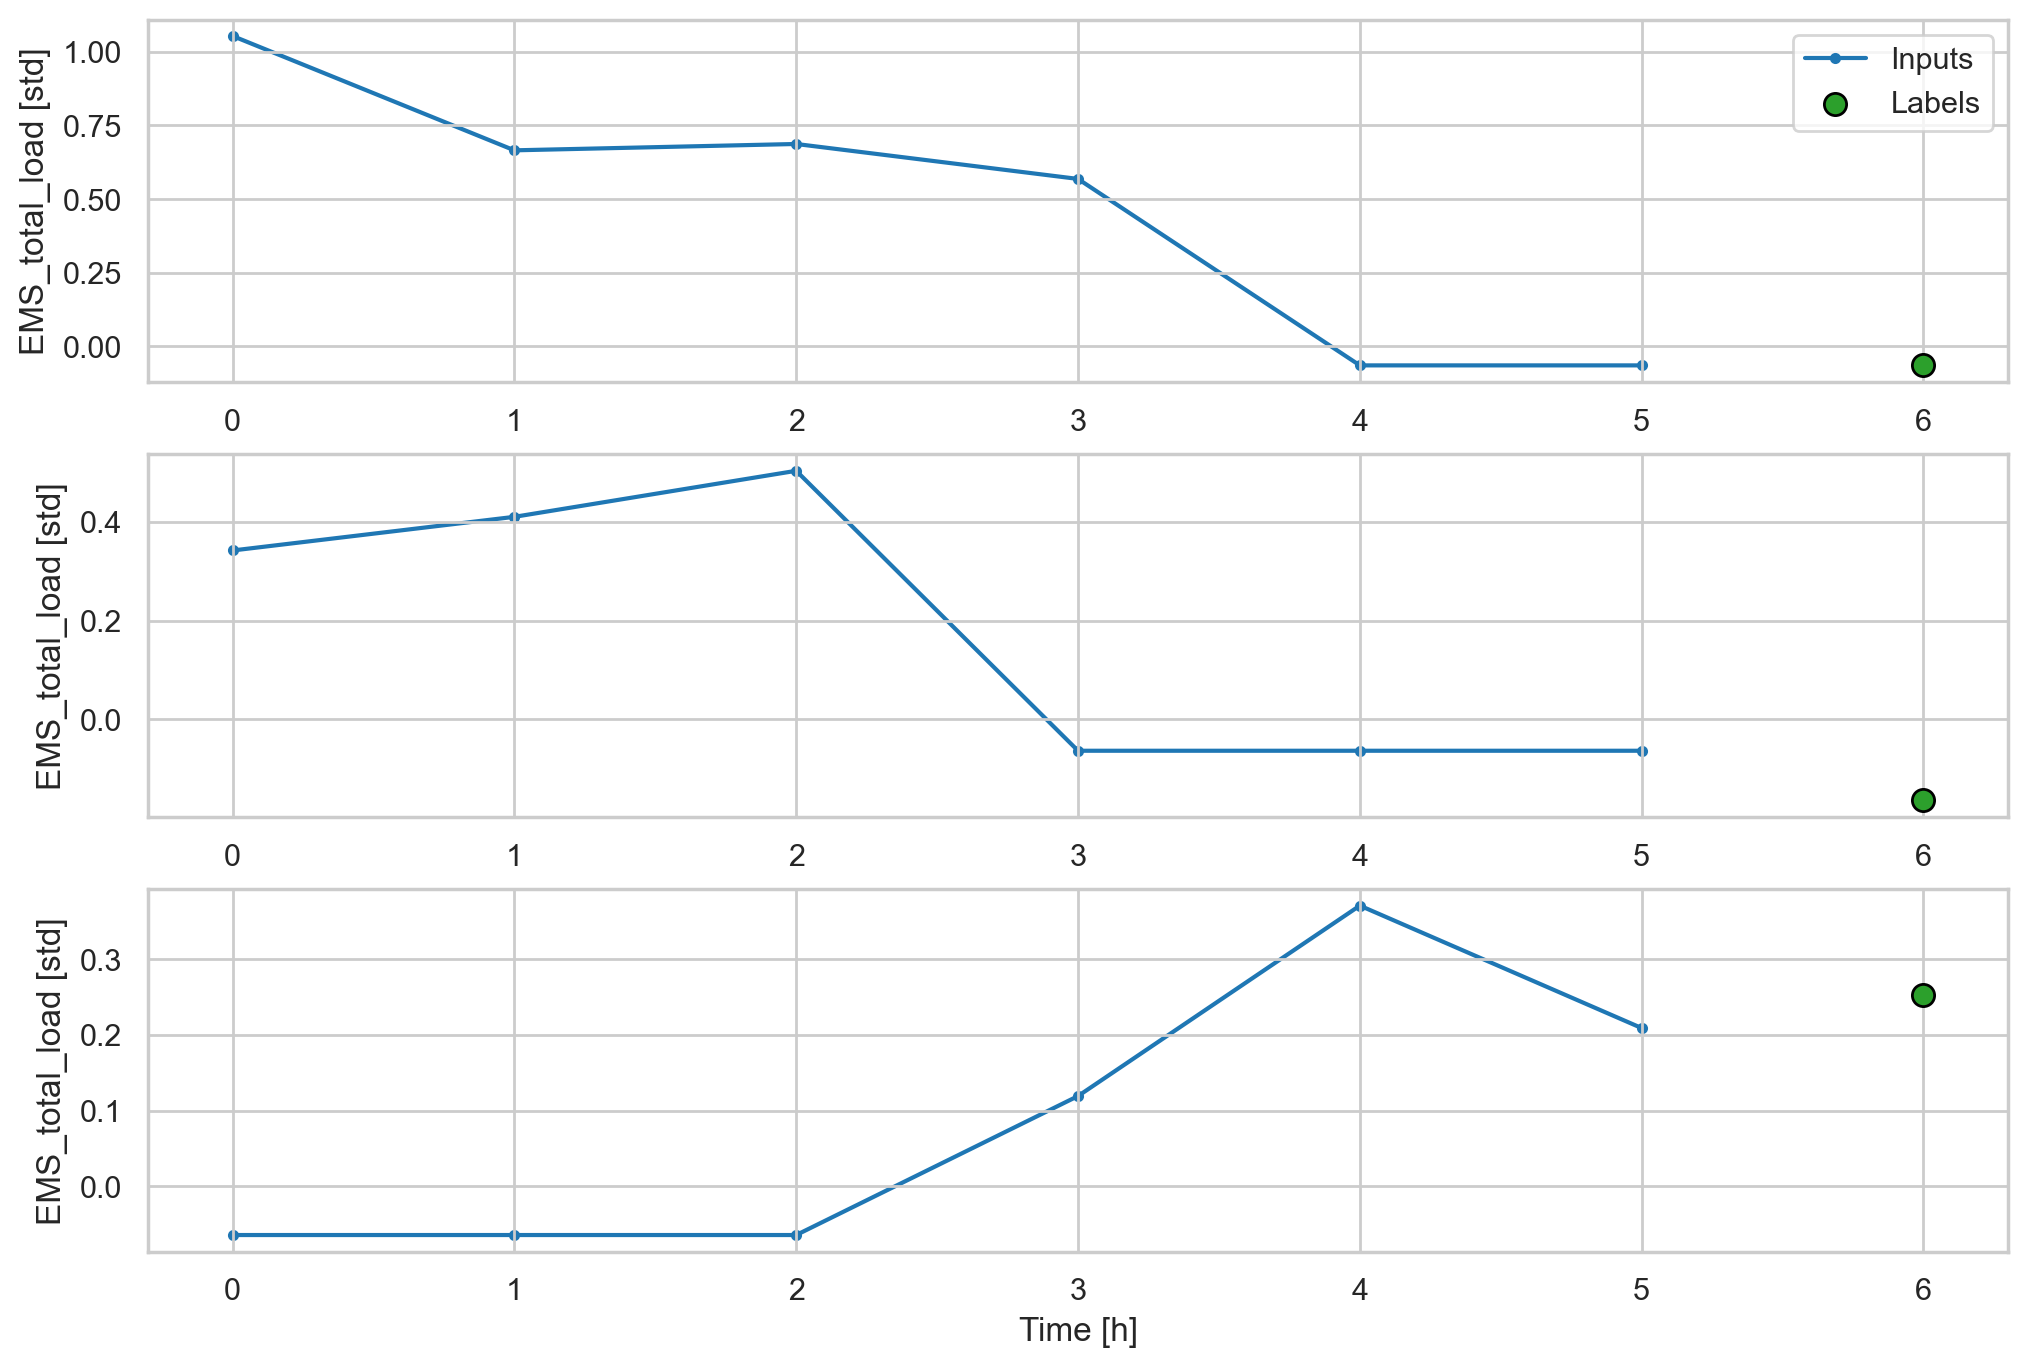

In [249]:
w2.plot()

## 3. Create tf.data.Datasets

In [250]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size, # Window size
      sequence_stride=1, # Step size between windows
      shuffle=True, # Shuffled randomly before each epoch
      batch_size=32,) # Number of samples used in each batch

  ds = ds.map(self.split_window) # Apply split_window function to each element of the dataset.

  return ds

WindowGenerator.make_dataset = make_dataset

In [251]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The `@property` decorator is used to define these properties as getter methods that can be accessed like class attributes.

`example` returns an example batch of inputs, labels for plotting. It first checks if an example batch is already cached as an attribute of the class using the `getattr` function. 

If not, it retrieves one from the `.train` dataset using the `next` function and the `iter` method, and caches it for later use using the `_example` attribute.

In [252]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

The `element_spec` attribute is a TensorFlow TensorSpec object that defines the structure and type of the elements in a TensorFlow dataset. 

It provides information about the shape, dtype, and other characteristics of the tensors that the dataset produces.

The code `w2.train.element_spec` returns the `element_spec` attribute of the TensorFlow dataset returned by the train property of the `WindowGenerator` instance `w2`.

In [253]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 10)
Labels shape (batch, time, features): (32, 1, 1)


The `.take(1)` method is used to retrieve only one batch of data from the train dataset.

### Create a single-step window

In [254]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['EMS_total_load'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['EMS_total_load']

### Single-step Baseline

In [255]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

The `Baseline` class has an `__init__` method that takes one optional argument label_index, and calls the `__init__` method of the parent class using `super().__init__()`. 

The label_index argument is used to specify the index of the label column that the model should use.

The `call` method is the main method for a `tf.keras.Model`, and it defines the forward pass of the model. This method takes inputs as an argument, which is the input data to the model. 

If the `label_index` attribute is `None`, the method returns the inputs as is.

Otherwise, the method selects the label column specified by `label_index` from the inputs tensor using slicing, and adds a new axis to the end of the resulting tensor using `tf.newaxis`. The resulting tensor is then returned.

So, the `Baseline` class defines a simple model that either returns the input data as is, or selects a single column specified by `label_index` and adds a new axis to the end of the resulting tensor.

In [256]:
baseline = Baseline(label_index=column_indices['EMS_total_load'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

28/28 [==============================] - 0s 1ms/step - loss: 0.3427 - mean_absolute_error: 0.3574


### Create a wide window

In [257]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['EMS_total_load'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['EMS_total_load']

In [258]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

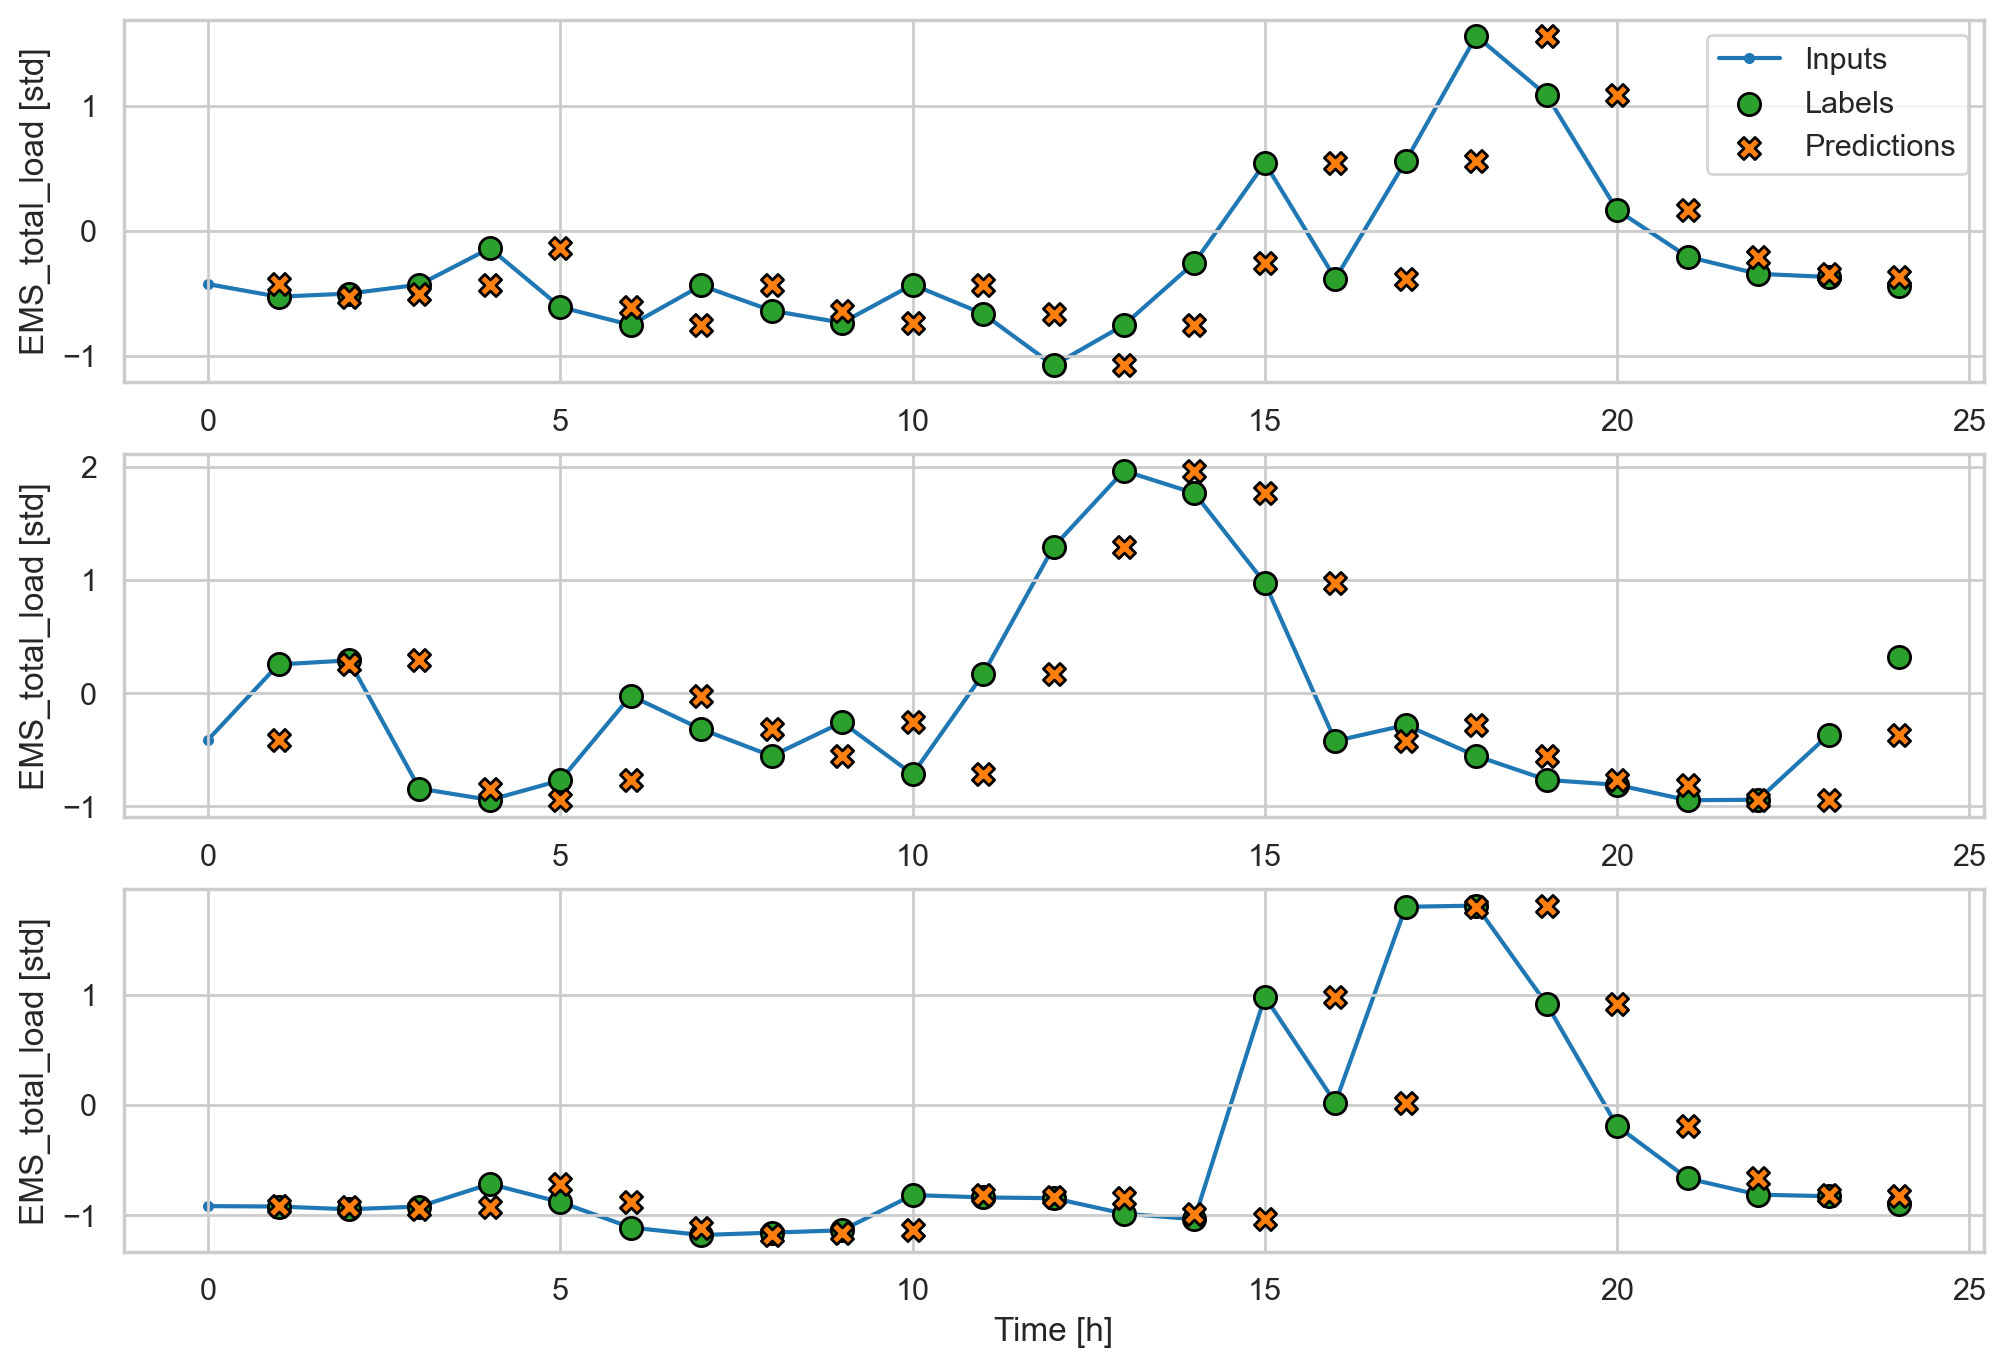

In [259]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input demand at each time step. The model receives all features, this plot only shows the demand.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Single-step Linear

In [260]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [261]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


## Training Procedure Function

In [262]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

The `EarlyStopping` callback will stop the training process if the validation loss hasn't improved after a certain number of epochs defined by the `patience` value.

In [263]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/40
219/219 [==============================] - 1s 2ms/step - loss: 1.7138 - mean_absolute_error: 1.0460 - val_loss: 0.9457 - val_mean_absolute_error: 0.7940
Epoch 2/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9250 - mean_absolute_error: 0.7573 - val_loss: 0.5451 - val_mean_absolute_error: 0.5813
Epoch 3/40
219/219 [==============================] - 0s 2ms/step - loss: 0.6054 - mean_absolute_error: 0.5890 - val_loss: 0.3625 - val_mean_absolute_error: 0.4522
Epoch 4/40
219/219 [==============================] - 0s 2ms/step - loss: 0.4730 - mean_absolute_error: 0.4964 - val_loss: 0.2935 - val_mean_absolute_error: 0.3889
Epoch 5/40
219/219 [==============================] - 0s 1ms/step - loss: 0.4226 - mean_absolute_error: 0.4546 - val_loss: 0.2729 - val_mean_absolute_error: 0.3716
Epoch 6/40
219/219 [==============================] - 0s 2ms/step - loss: 0.4055 - mean_absolute_error: 0.4407 - val_loss: 0.2687 - val_mean_absolute_error: 0.3681
Epoch 7/40
219/2

In [264]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


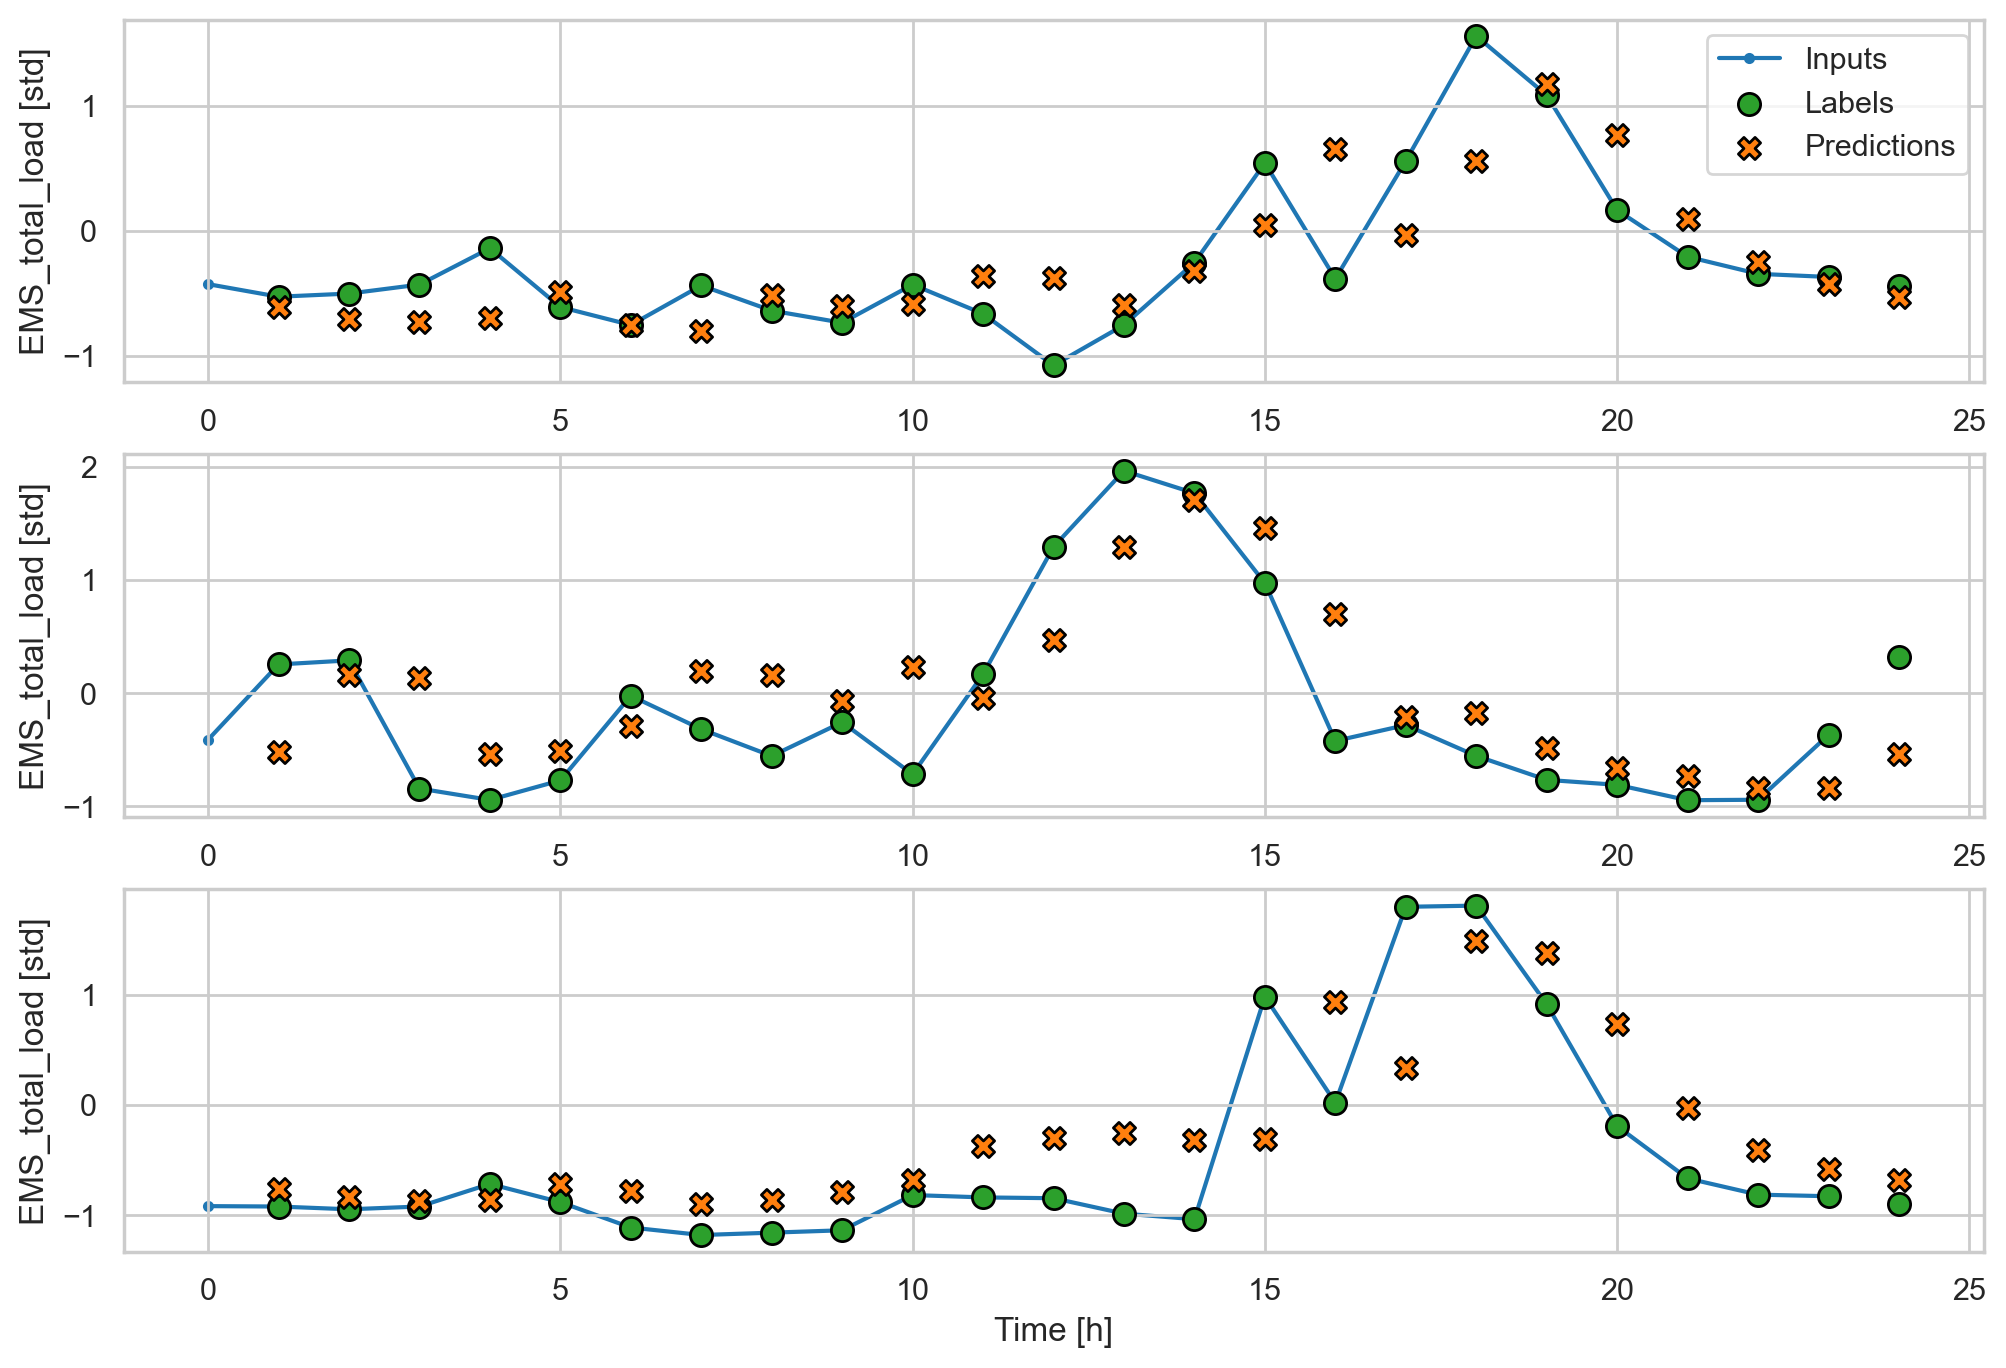

In [265]:
wide_window.plot(linear)

### Plot Linear Weights

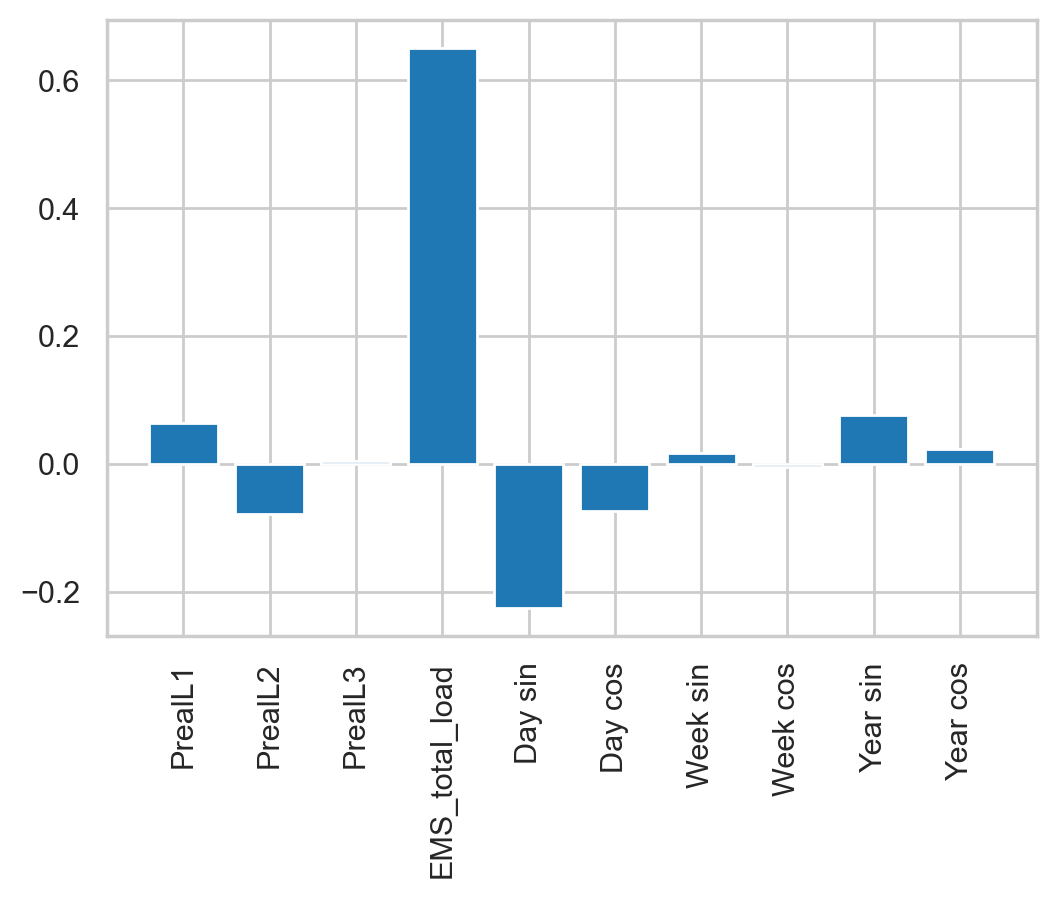

In [330]:
plt.figure(figsize=(6, 4))
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [267]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/40
219/219 [==============================] - 2s 3ms/step - loss: 0.4915 - mean_absolute_error: 0.4933 - val_loss: 0.2644 - val_mean_absolute_error: 0.3550
Epoch 2/40
219/219 [==============================] - 1s 3ms/step - loss: 0.3708 - mean_absolute_error: 0.4158 - val_loss: 0.2345 - val_mean_absolute_error: 0.3256
Epoch 3/40
219/219 [==============================] - 1s 2ms/step - loss: 0.3324 - mean_absolute_error: 0.3945 - val_loss: 0.2104 - val_mean_absolute_error: 0.3155
Epoch 4/40
219/219 [==============================] - 0s 2ms/step - loss: 0.3014 - mean_absolute_error: 0.3765 - val_loss: 0.1908 - val_mean_absolute_error: 0.3017
Epoch 5/40
219/219 [==============================] - 0s 2ms/step - loss: 0.2762 - mean_absolute_error: 0.3591 - val_loss: 0.1757 - val_mean_absolute_error: 0.2843
Epoch 6/40
219/219 [==============================] - 0s 2ms/step - loss: 0.2610 - mean_absolute_error: 0.3493 - val_loss: 0.1681 - val_mean_absolute_error: 0.2885
Epoch 7/40
219/2

In [268]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', dense(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


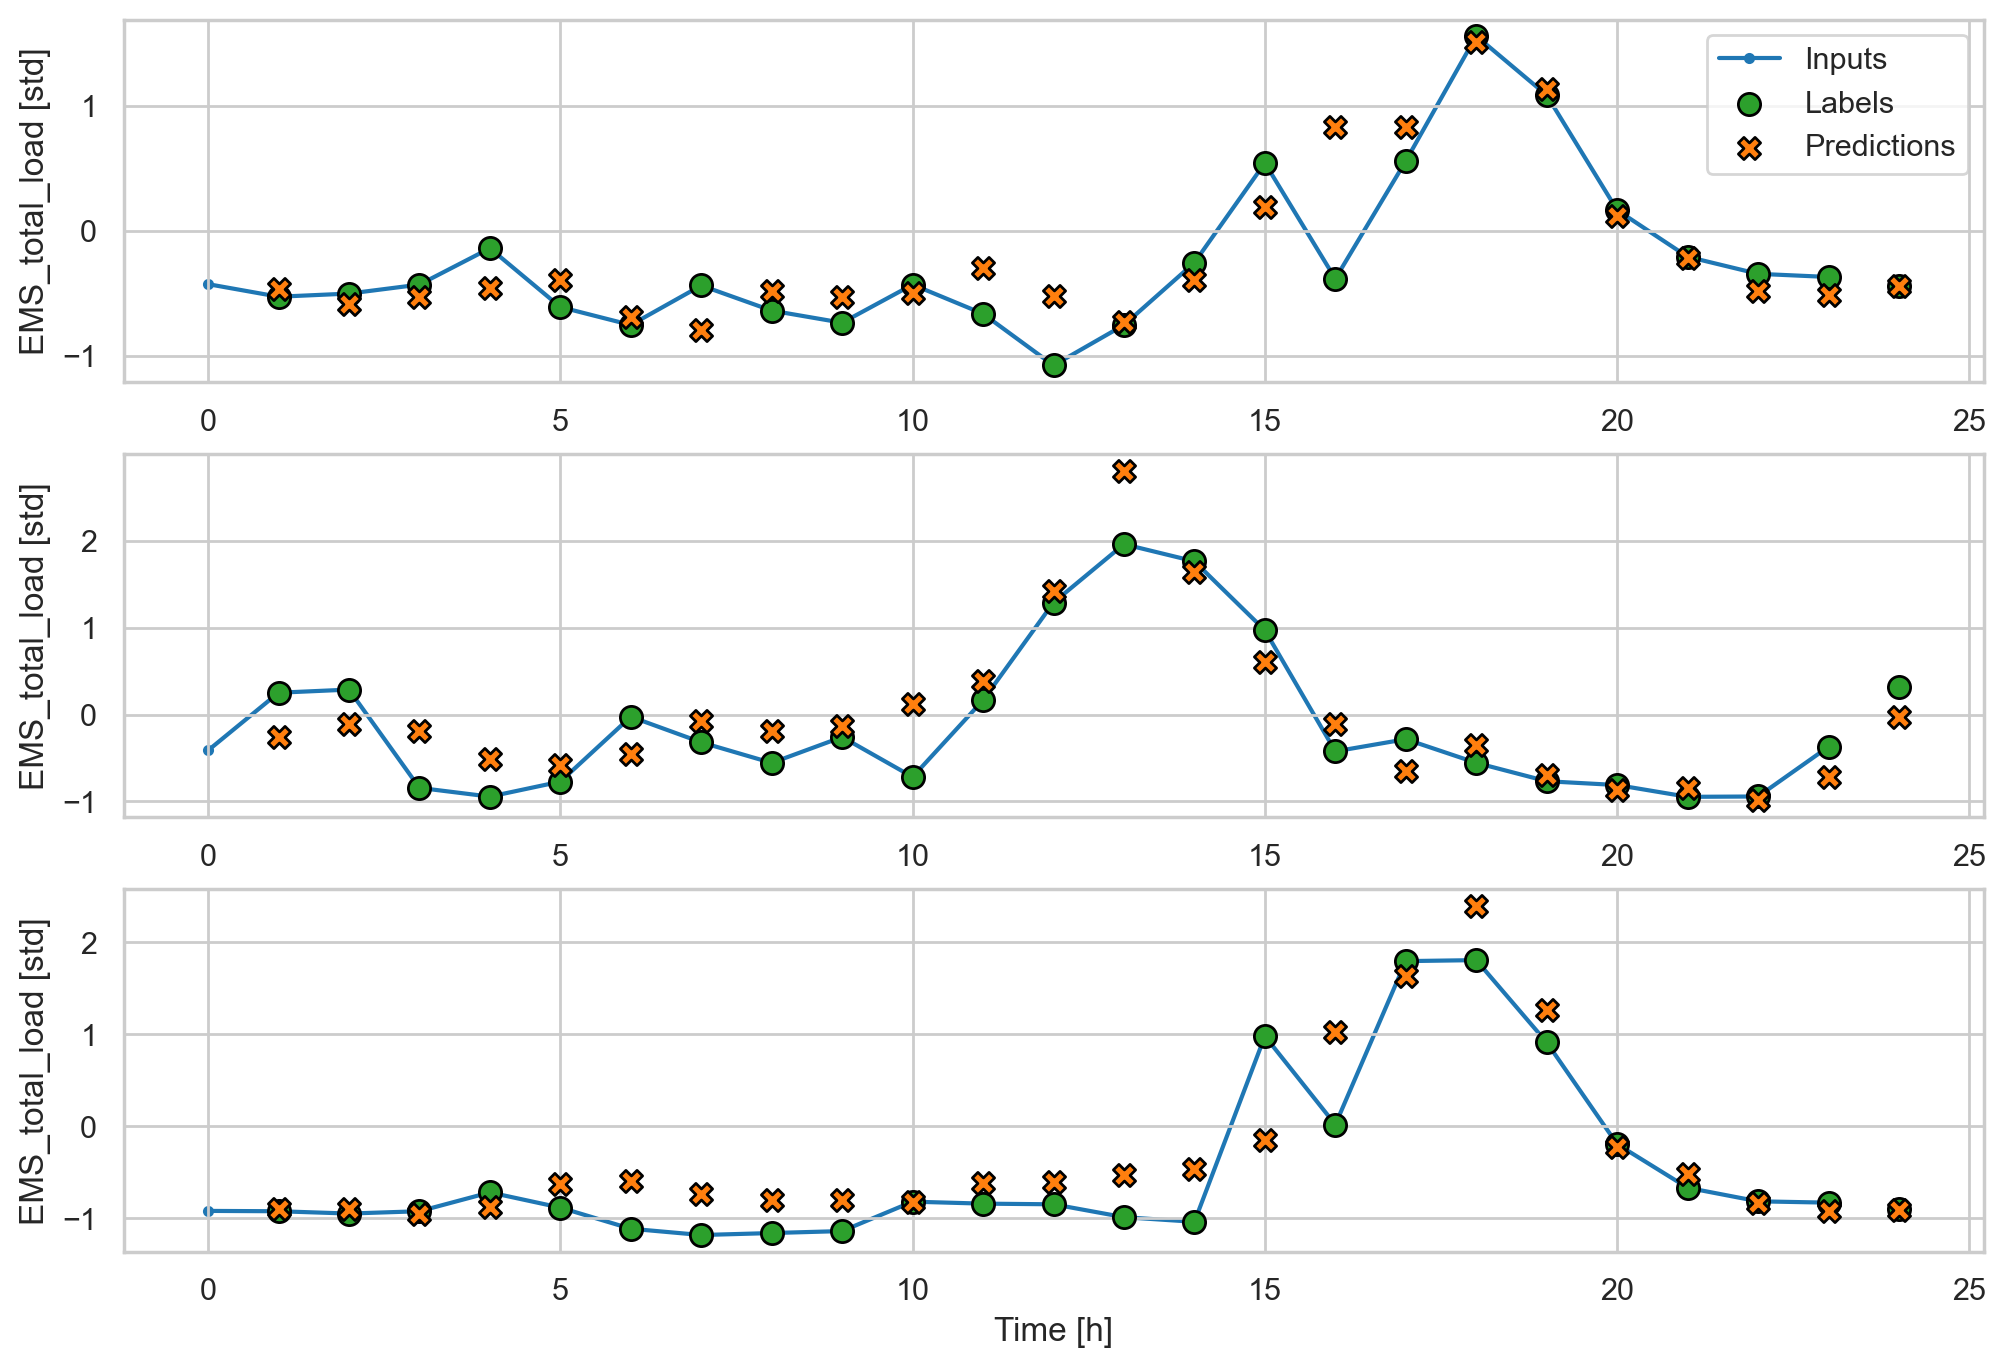

In [269]:
wide_window.plot(dense)

The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

In [270]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['EMS_total_load'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['EMS_total_load']

Text(0.5, 1.0, 'Given 24 hours of inputs, predict 1 hour into the future.')

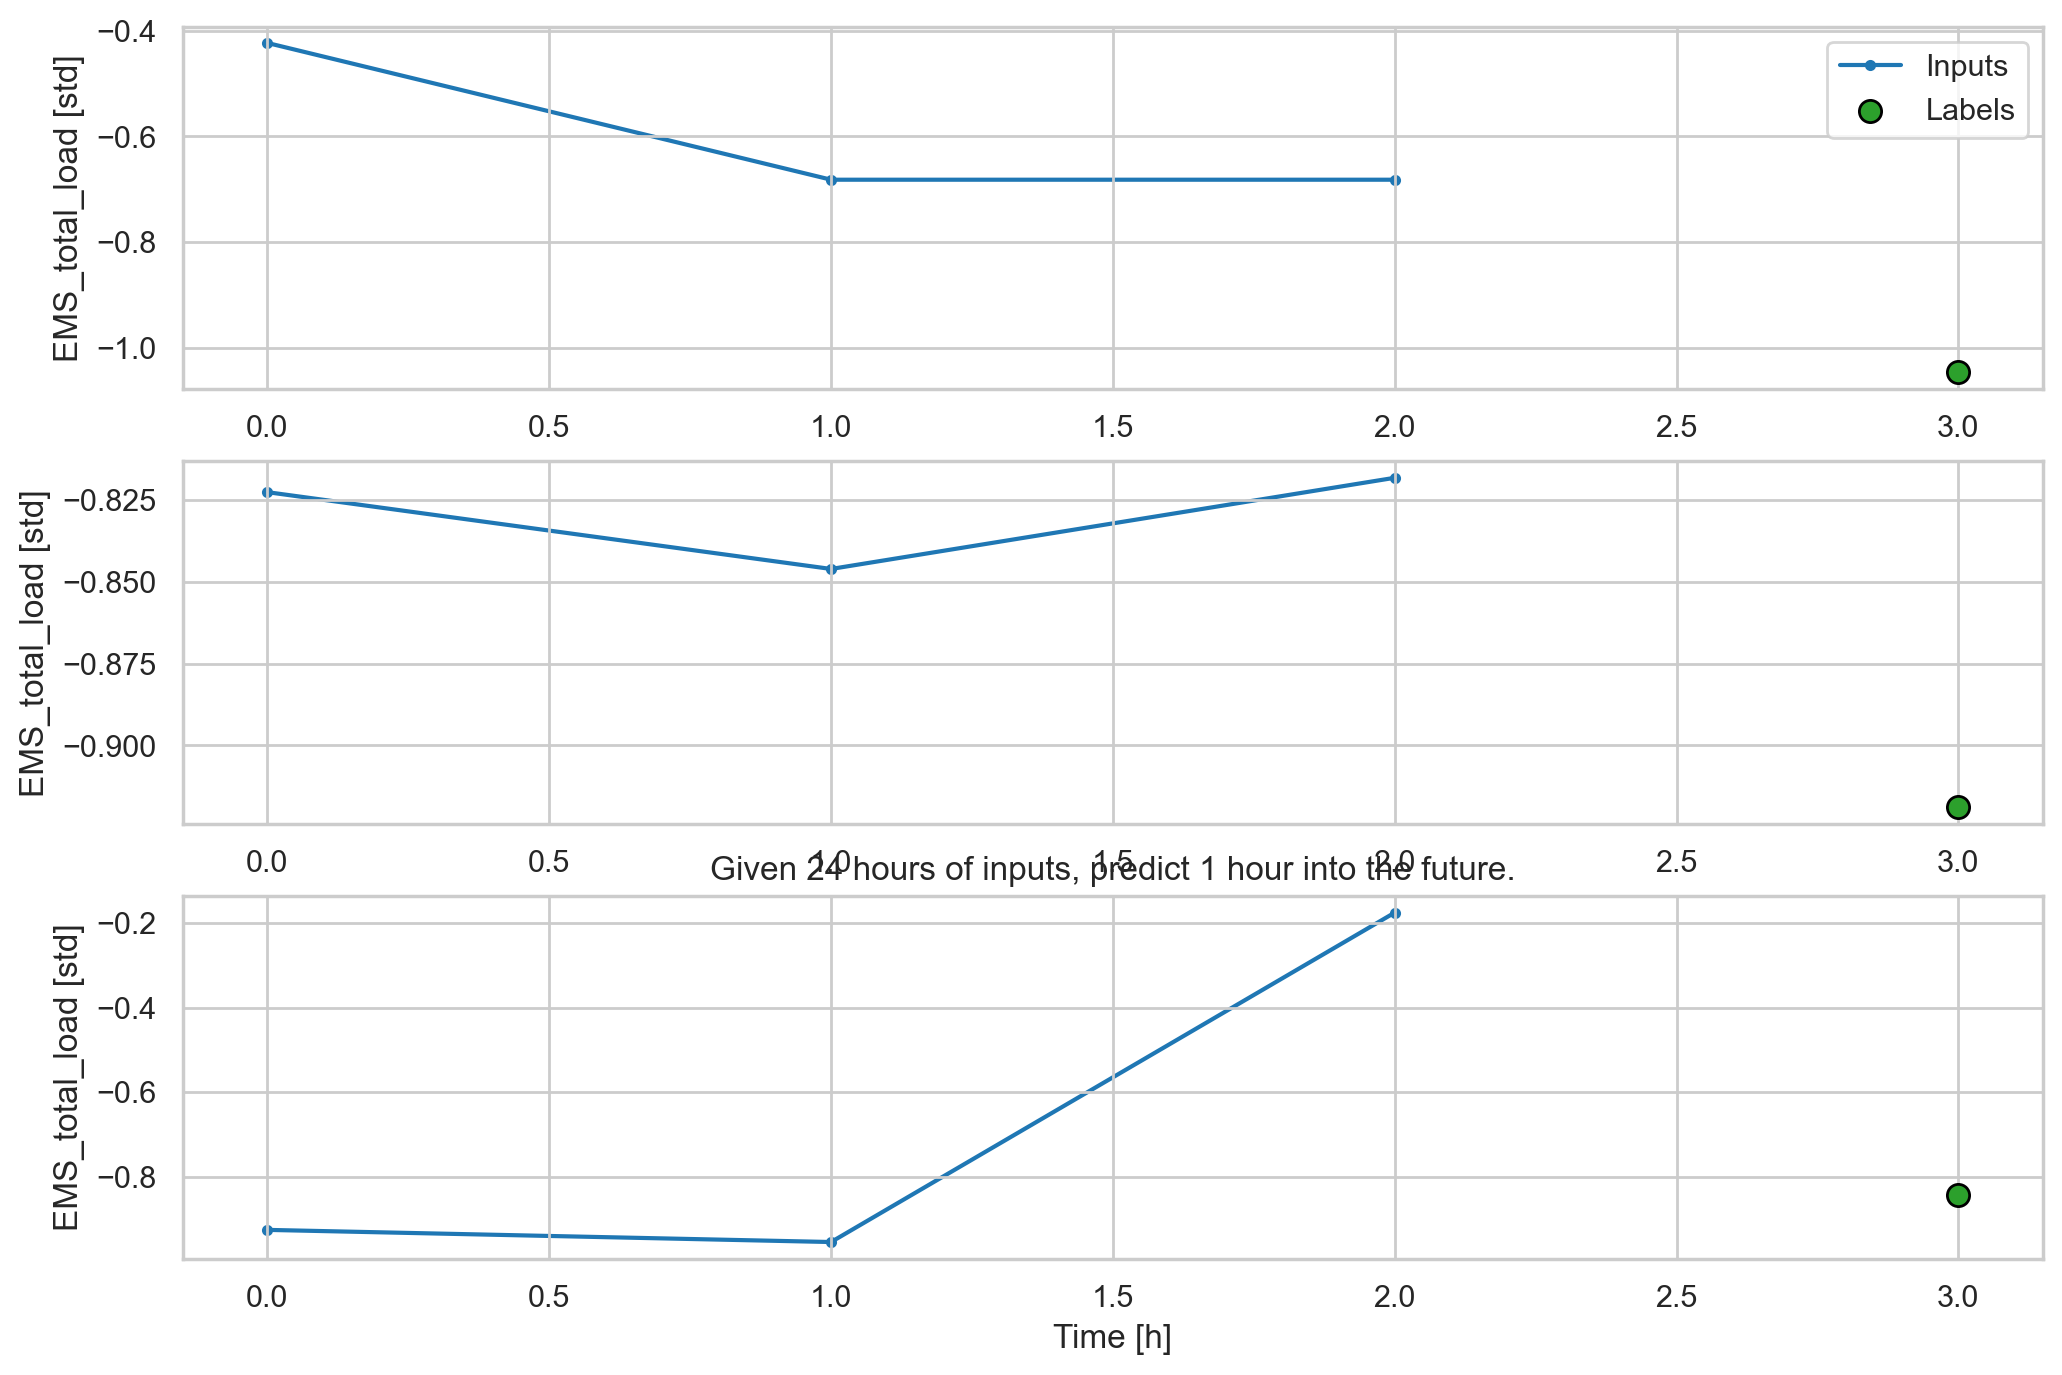

In [271]:
conv_window.plot()
plt.title("Given 24 hours of inputs, predict 1 hour into the future.")

In [272]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [273]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 10)
Output shape: (32, 1, 1)


In [274]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

28/28 [==============================] - 0s 1ms/step - loss: 0.1582 - mean_absolute_error: 0.2898


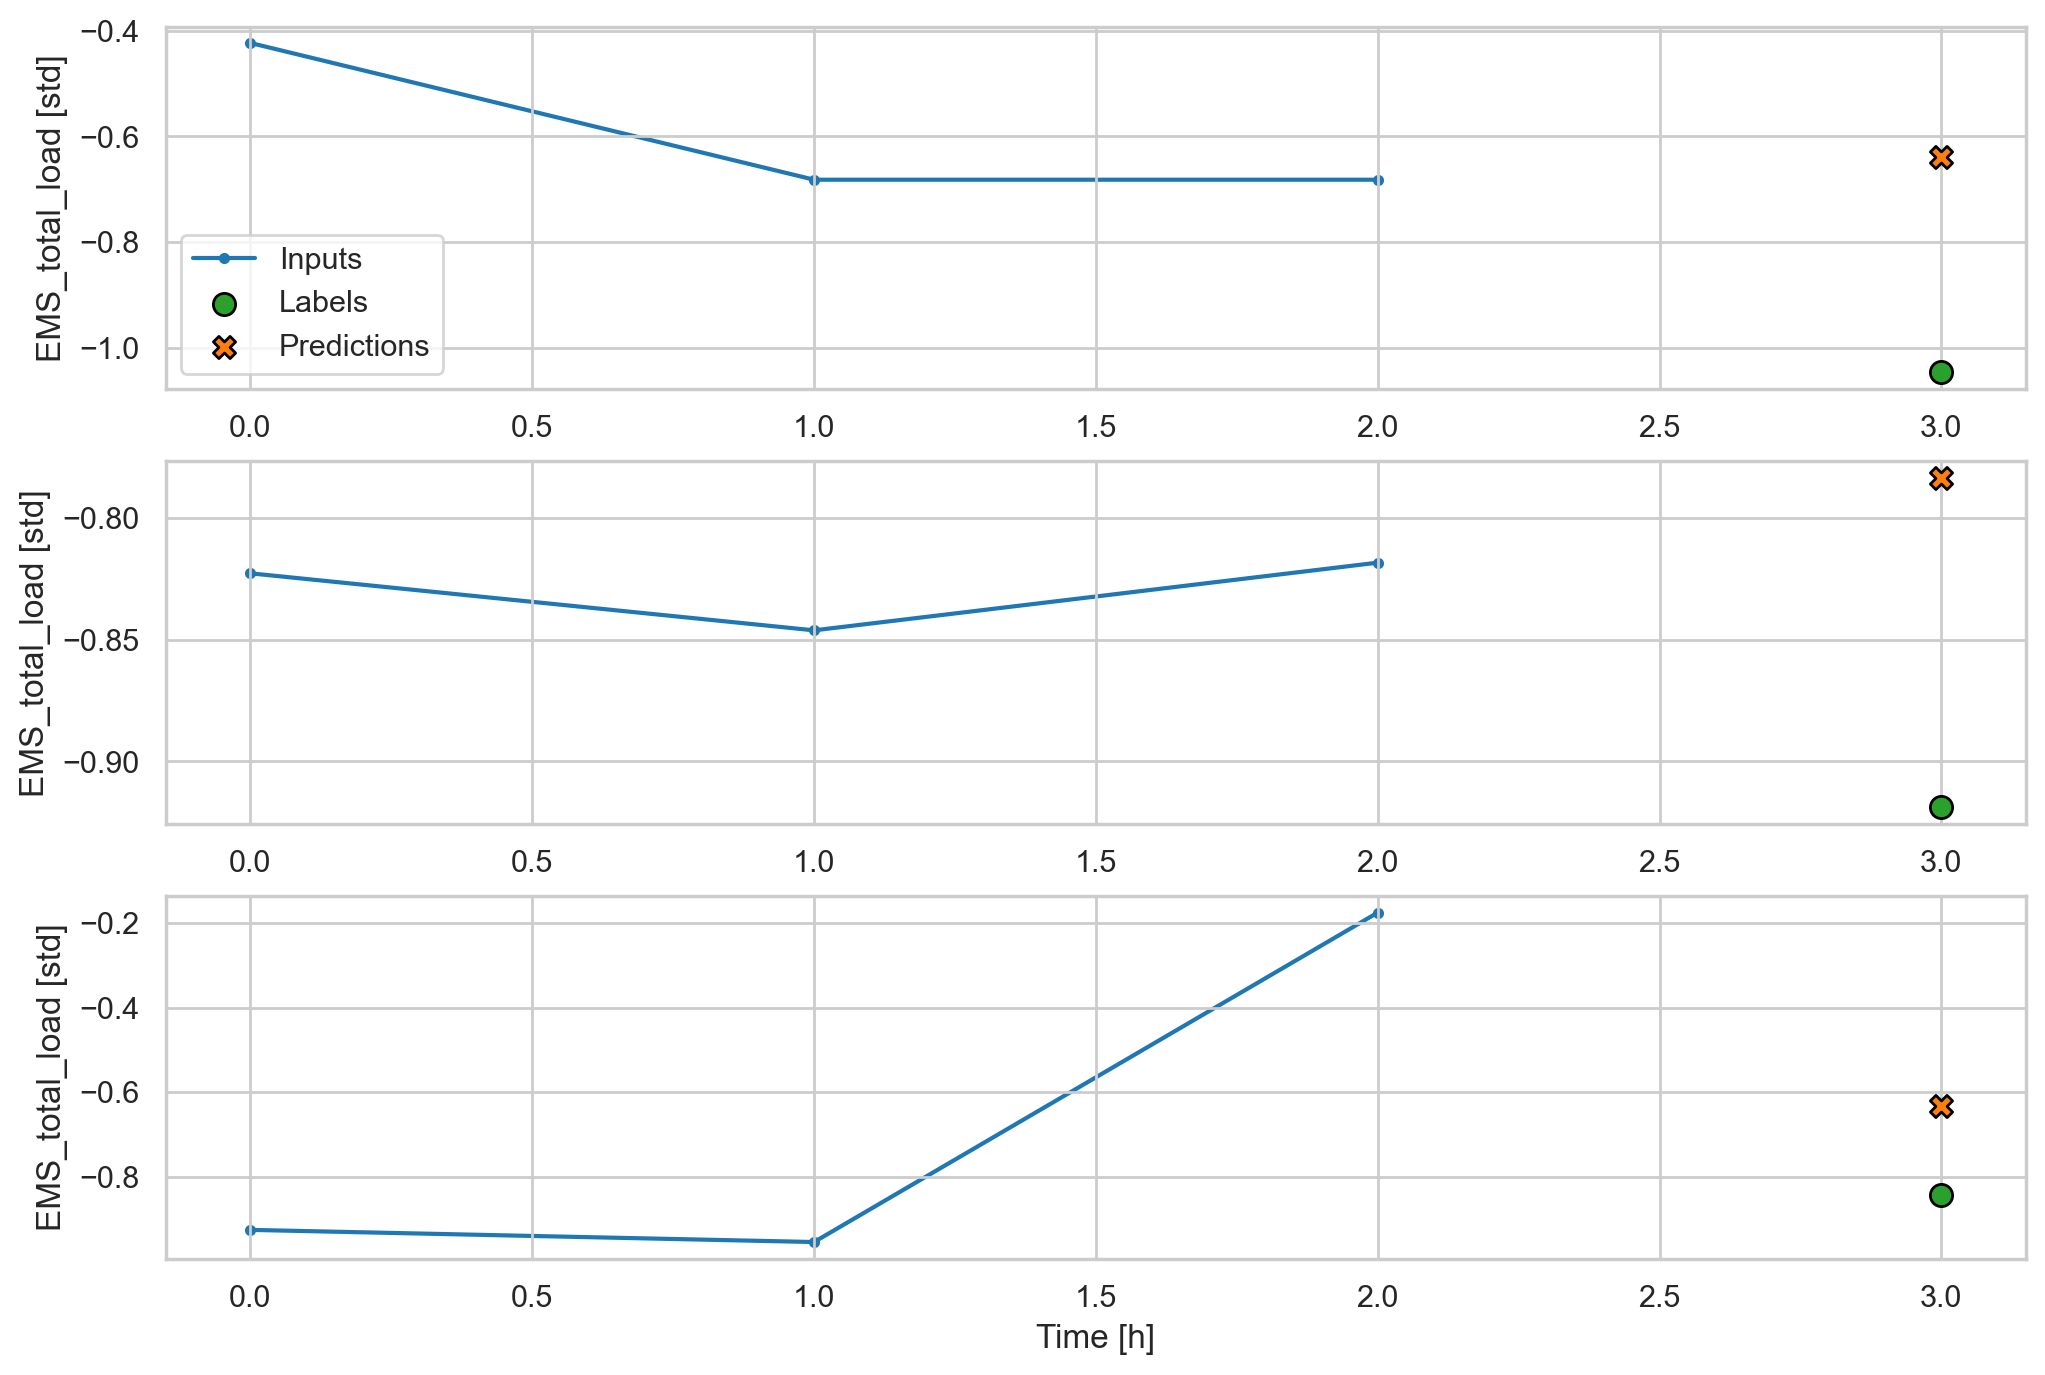

In [275]:
conv_window.plot(multi_step_dense)

## Convolutional neural network

A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [276]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [277]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 10)
Output shape: (32, 1, 1)


In [278]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

28/28 [==============================] - 0s 2ms/step - loss: 0.1903 - mean_absolute_error: 0.2861


In [279]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 10)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [280]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['EMS_total_load'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['EMS_total_load']

In [281]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 10)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

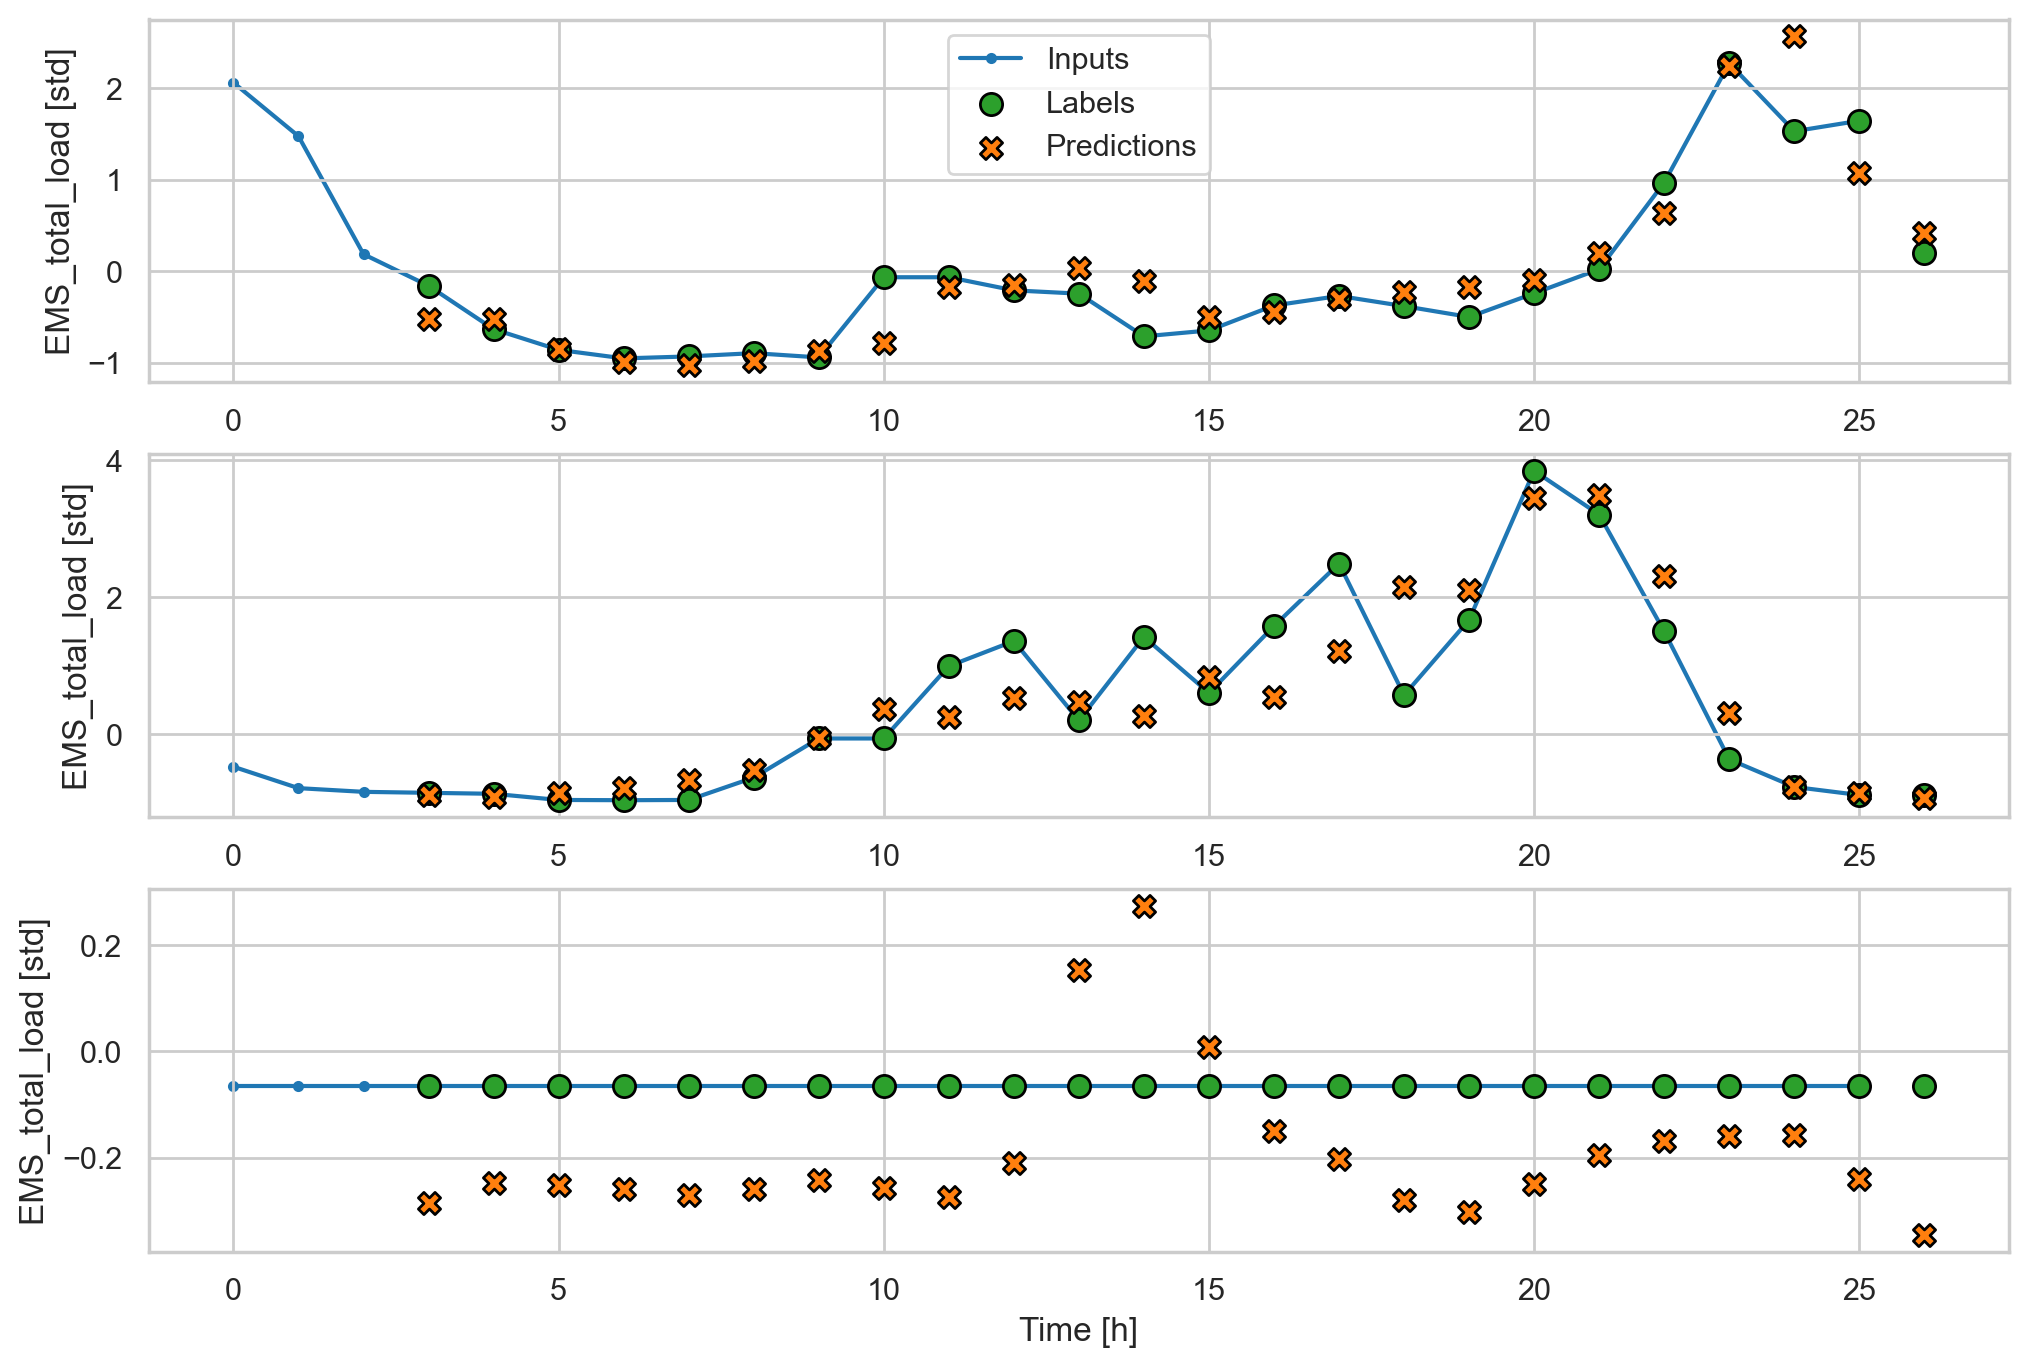

In [282]:
wide_conv_window.plot(conv_model)

## Recurrent neural network

In [335]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [336]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


In [337]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

27/27 [==============================] - 0s 5ms/step - loss: 0.1519 - mean_absolute_error: 0.2756


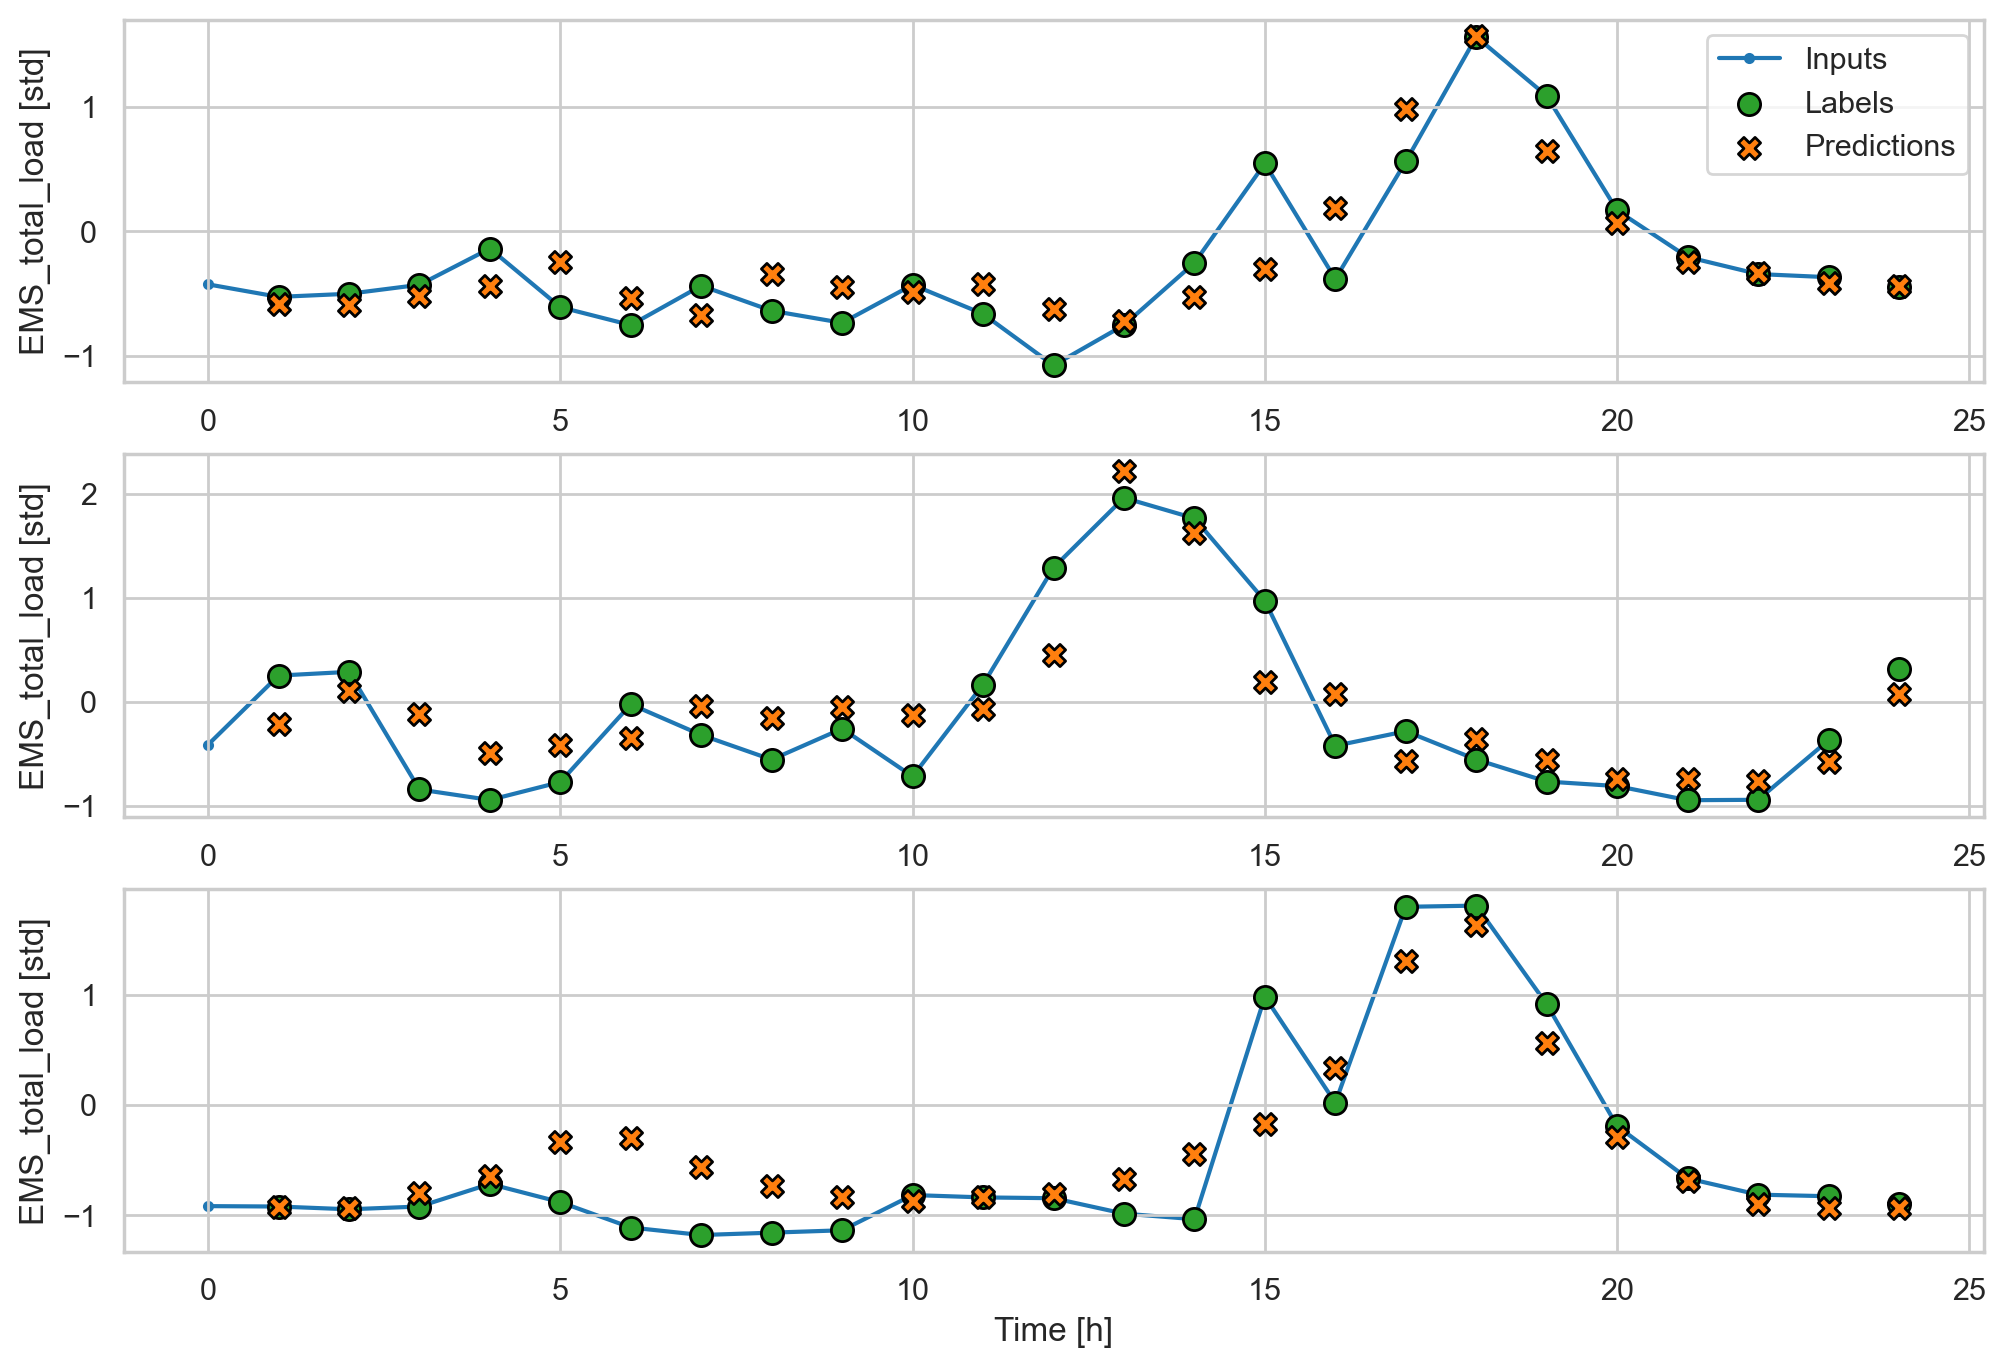

In [338]:
wide_window.plot(lstm_model)

## Performance

Text(0.5, 1.0, 'Electrical Load')

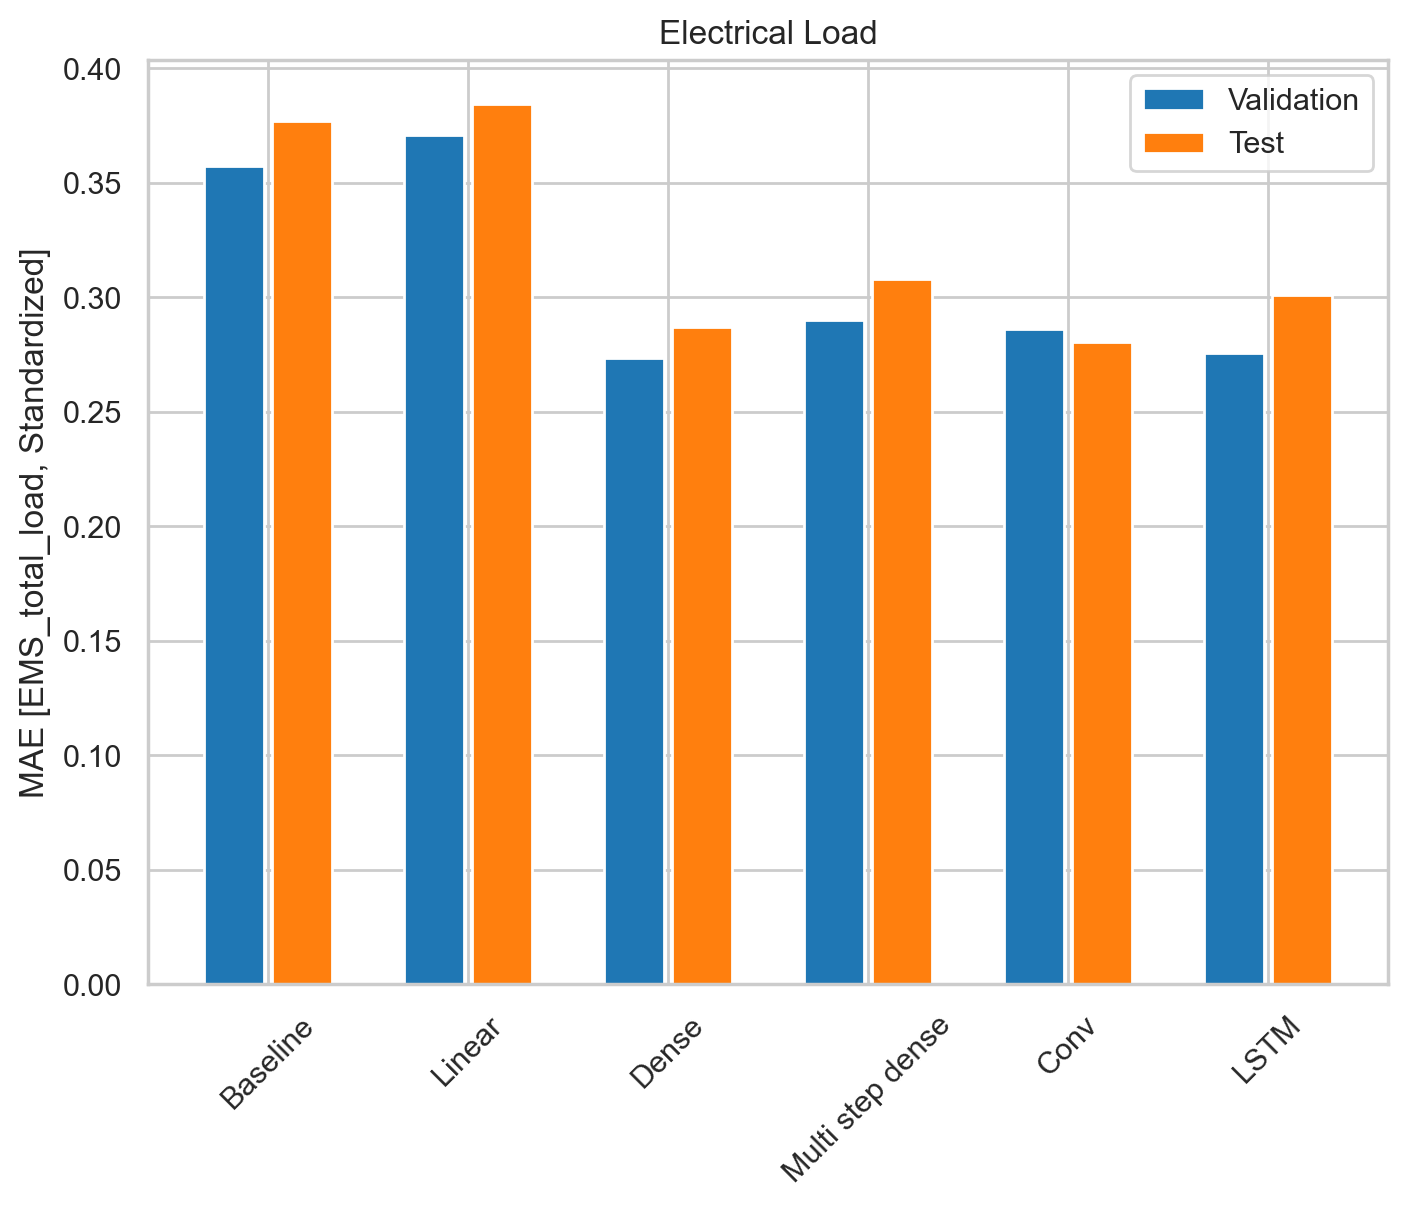

In [340]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('MAE [EMS_total_load, Standardized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.title('Electrical Load')

# Multi-step Models


The single-output models in the previous sectionsmade **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['EMS_total_load']

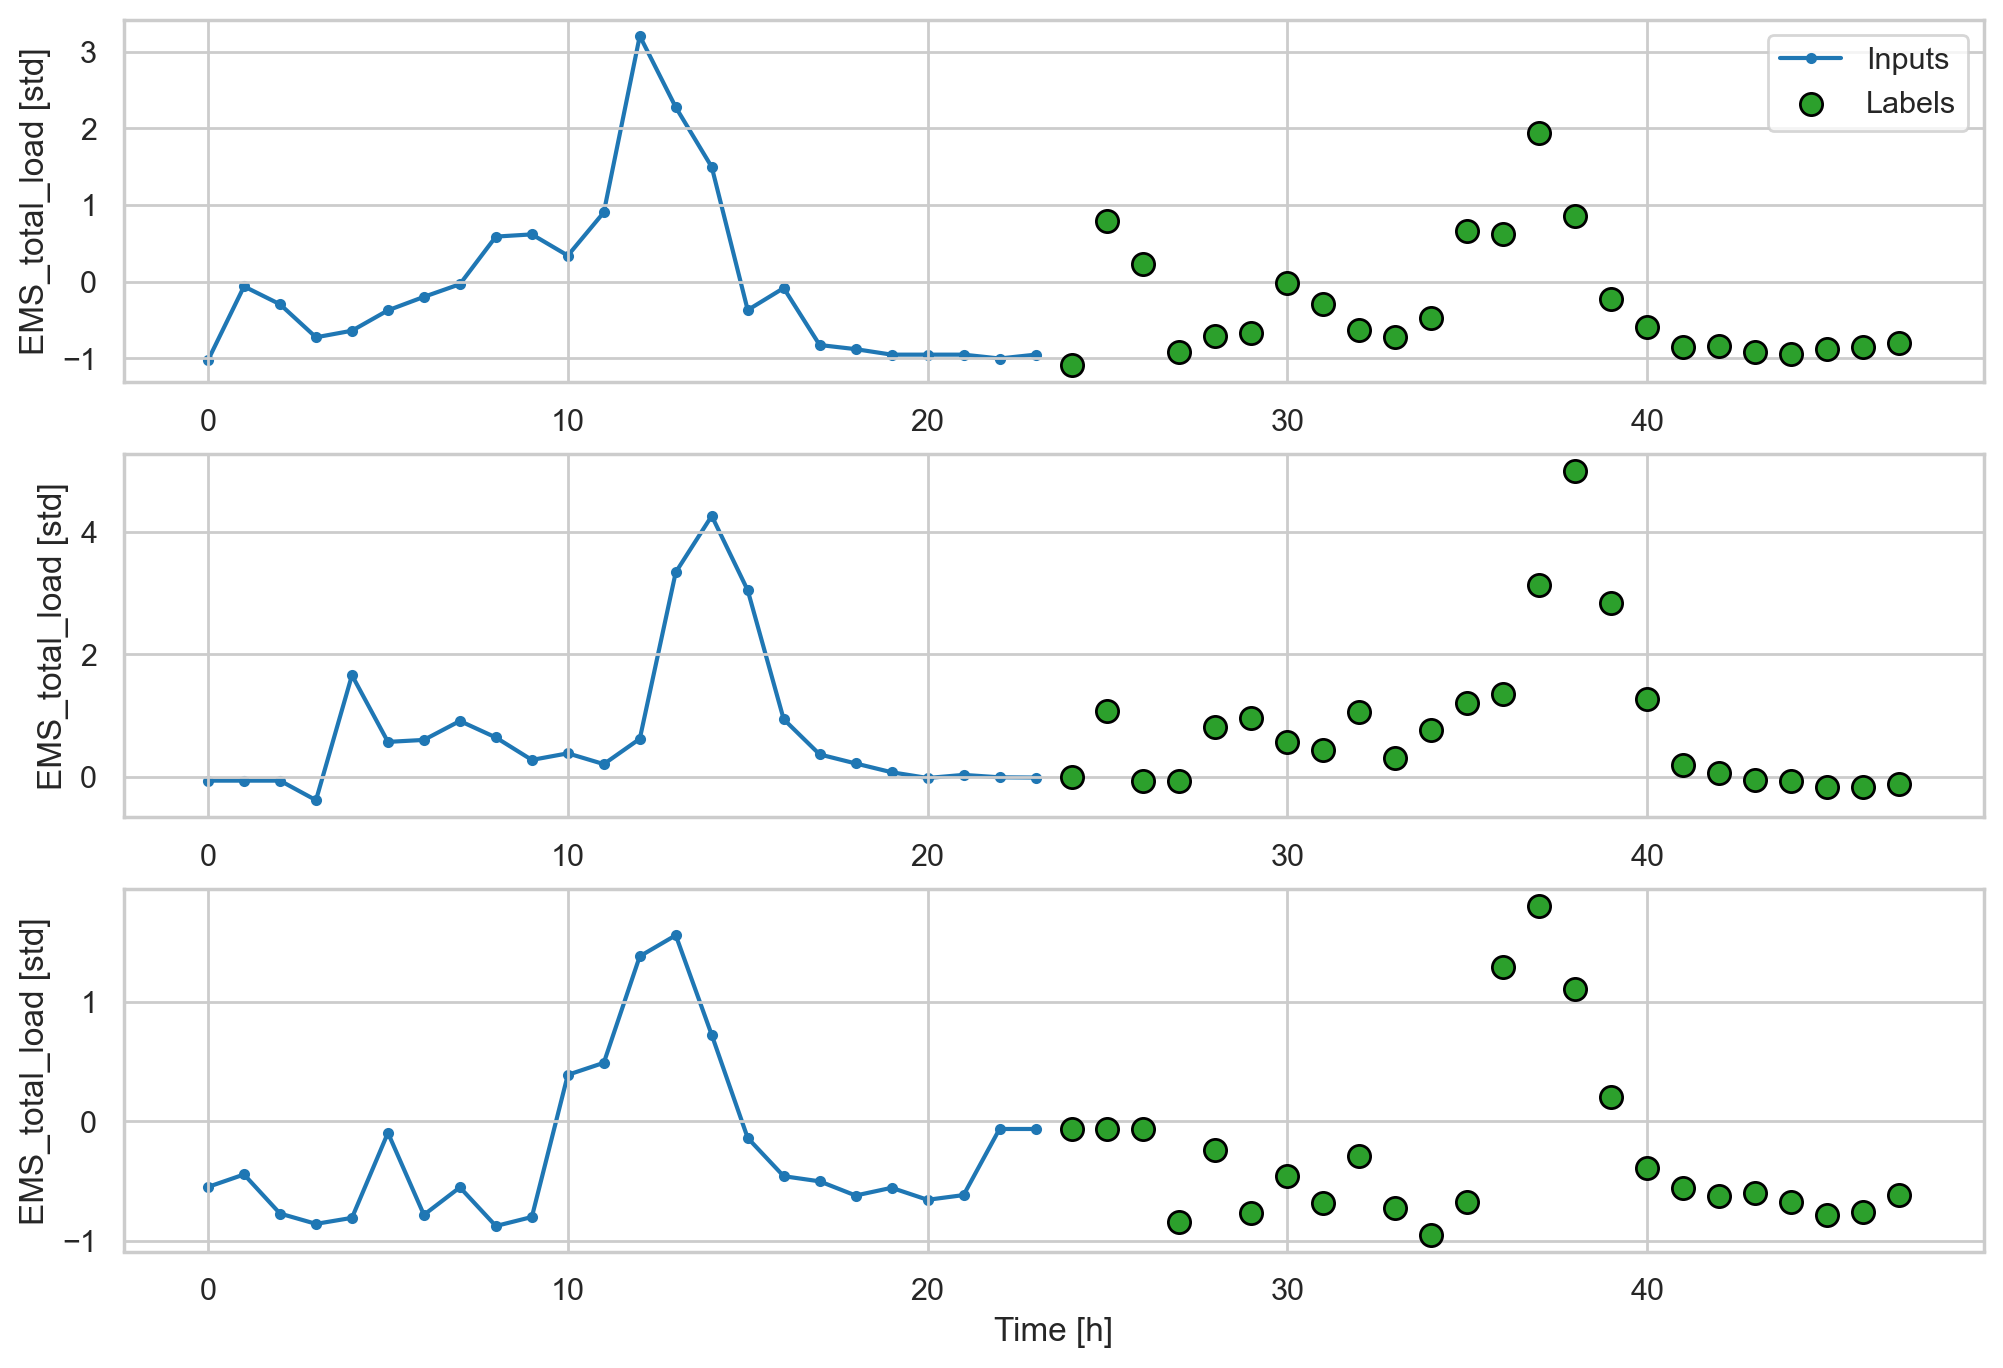

In [288]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['EMS_total_load'])

multi_window.plot()
multi_window

## Baselines

#### Last

In [289]:
column_indices['EMS_total_load']

3

In [290]:
class MultiStepLastBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index= label_index

  def call(self, inputs):
    if self.label_index is None:
      return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    else:
      selected_feature = inputs[:, -1:, self.label_index:self.label_index+1]
      return tf.tile(selected_feature, [1, OUT_STEPS, 1])

26/26 [==============================] - 0s 2ms/step - loss: 1.2154 - mean_absolute_error: 0.7330


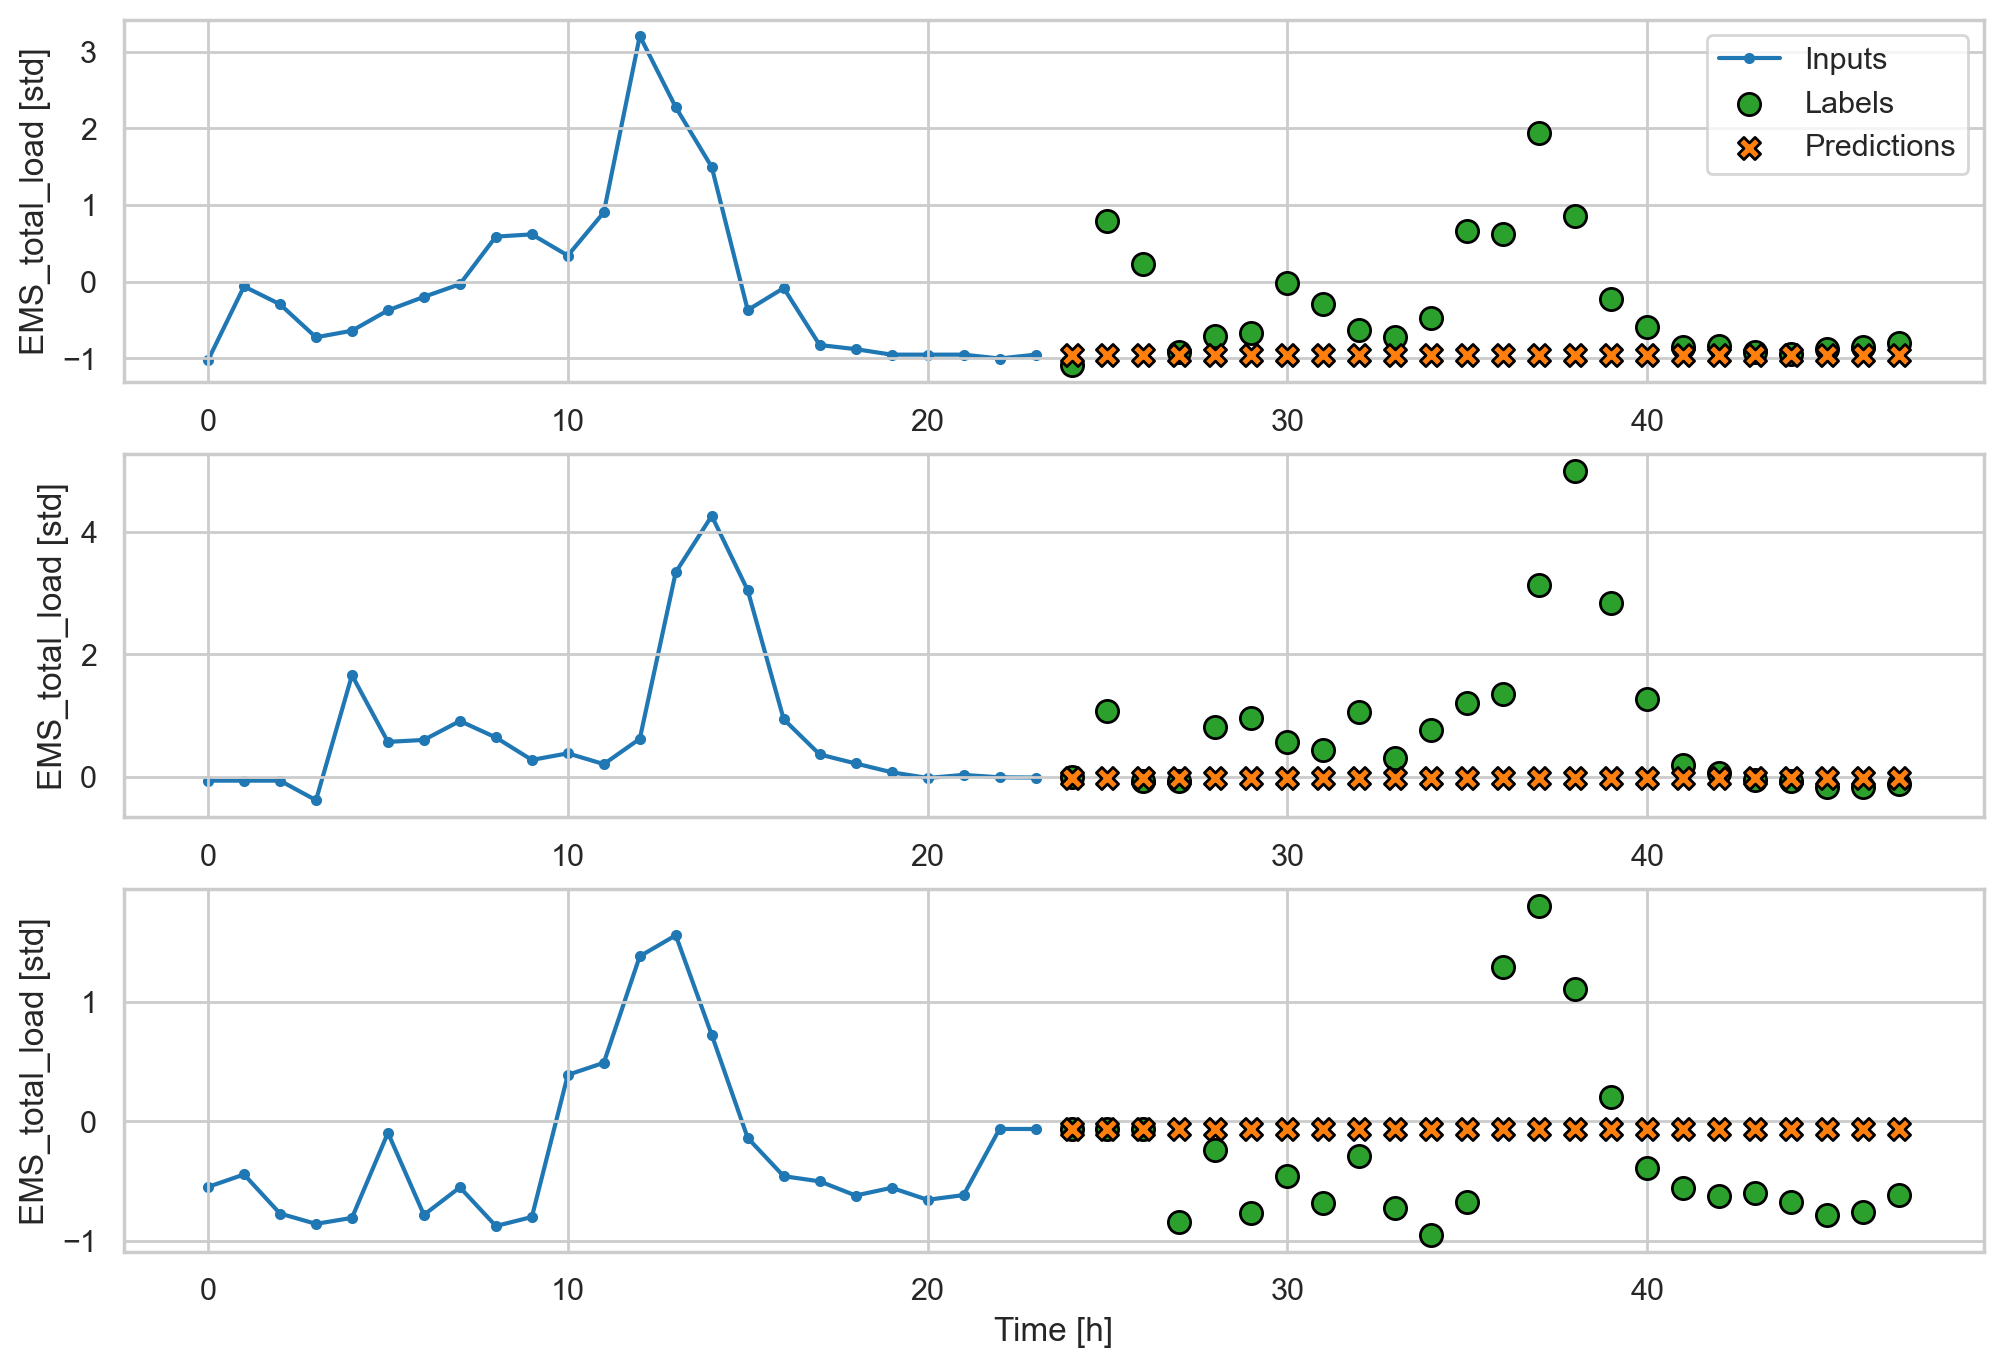

In [291]:
# class MultiStepLastBaseline(tf.keras.Model):
#   def call(self, inputs):
#     return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline(label_index=column_indices['EMS_total_load'])
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [292]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', last_baseline(multi_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


#### Repeat

In [293]:
class RepeatBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

26/26 [==============================] - 0s 2ms/step - loss: 0.1842 - mean_absolute_error: 0.2906


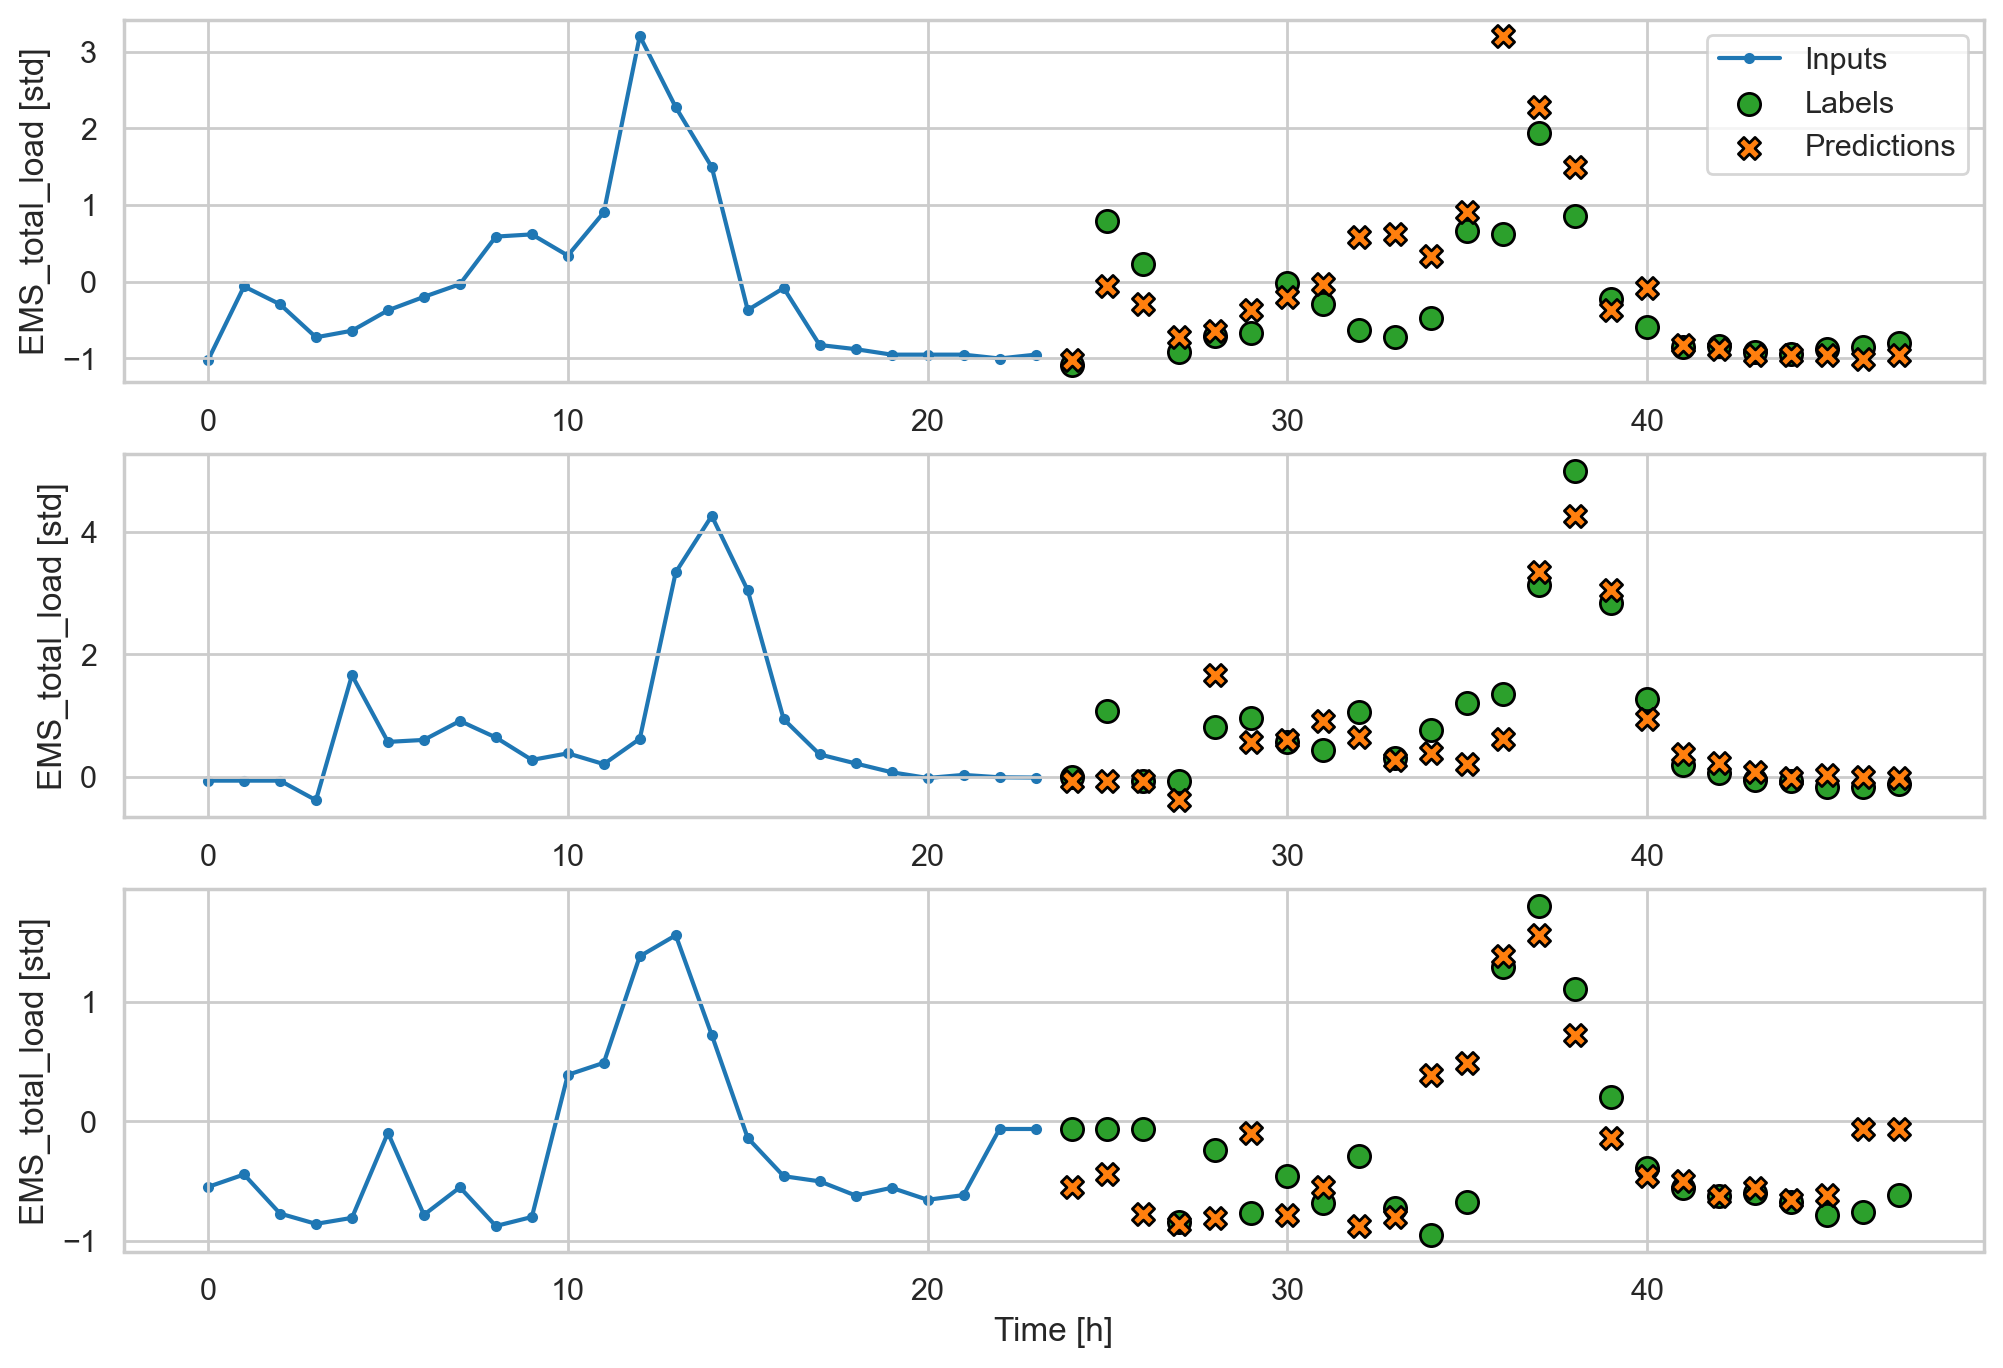

In [294]:
# class RepeatBaseline(tf.keras.Model):
#   def call(self, inputs):
#     return inputs

repeat_baseline = RepeatBaseline(label_index=column_indices['EMS_total_load'])
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [295]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', repeat_baseline(multi_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


## Single shot models

### Multi-linear Model

26/26 [==============================] - 0s 1ms/step - loss: 0.4107 - mean_absolute_error: 0.5069


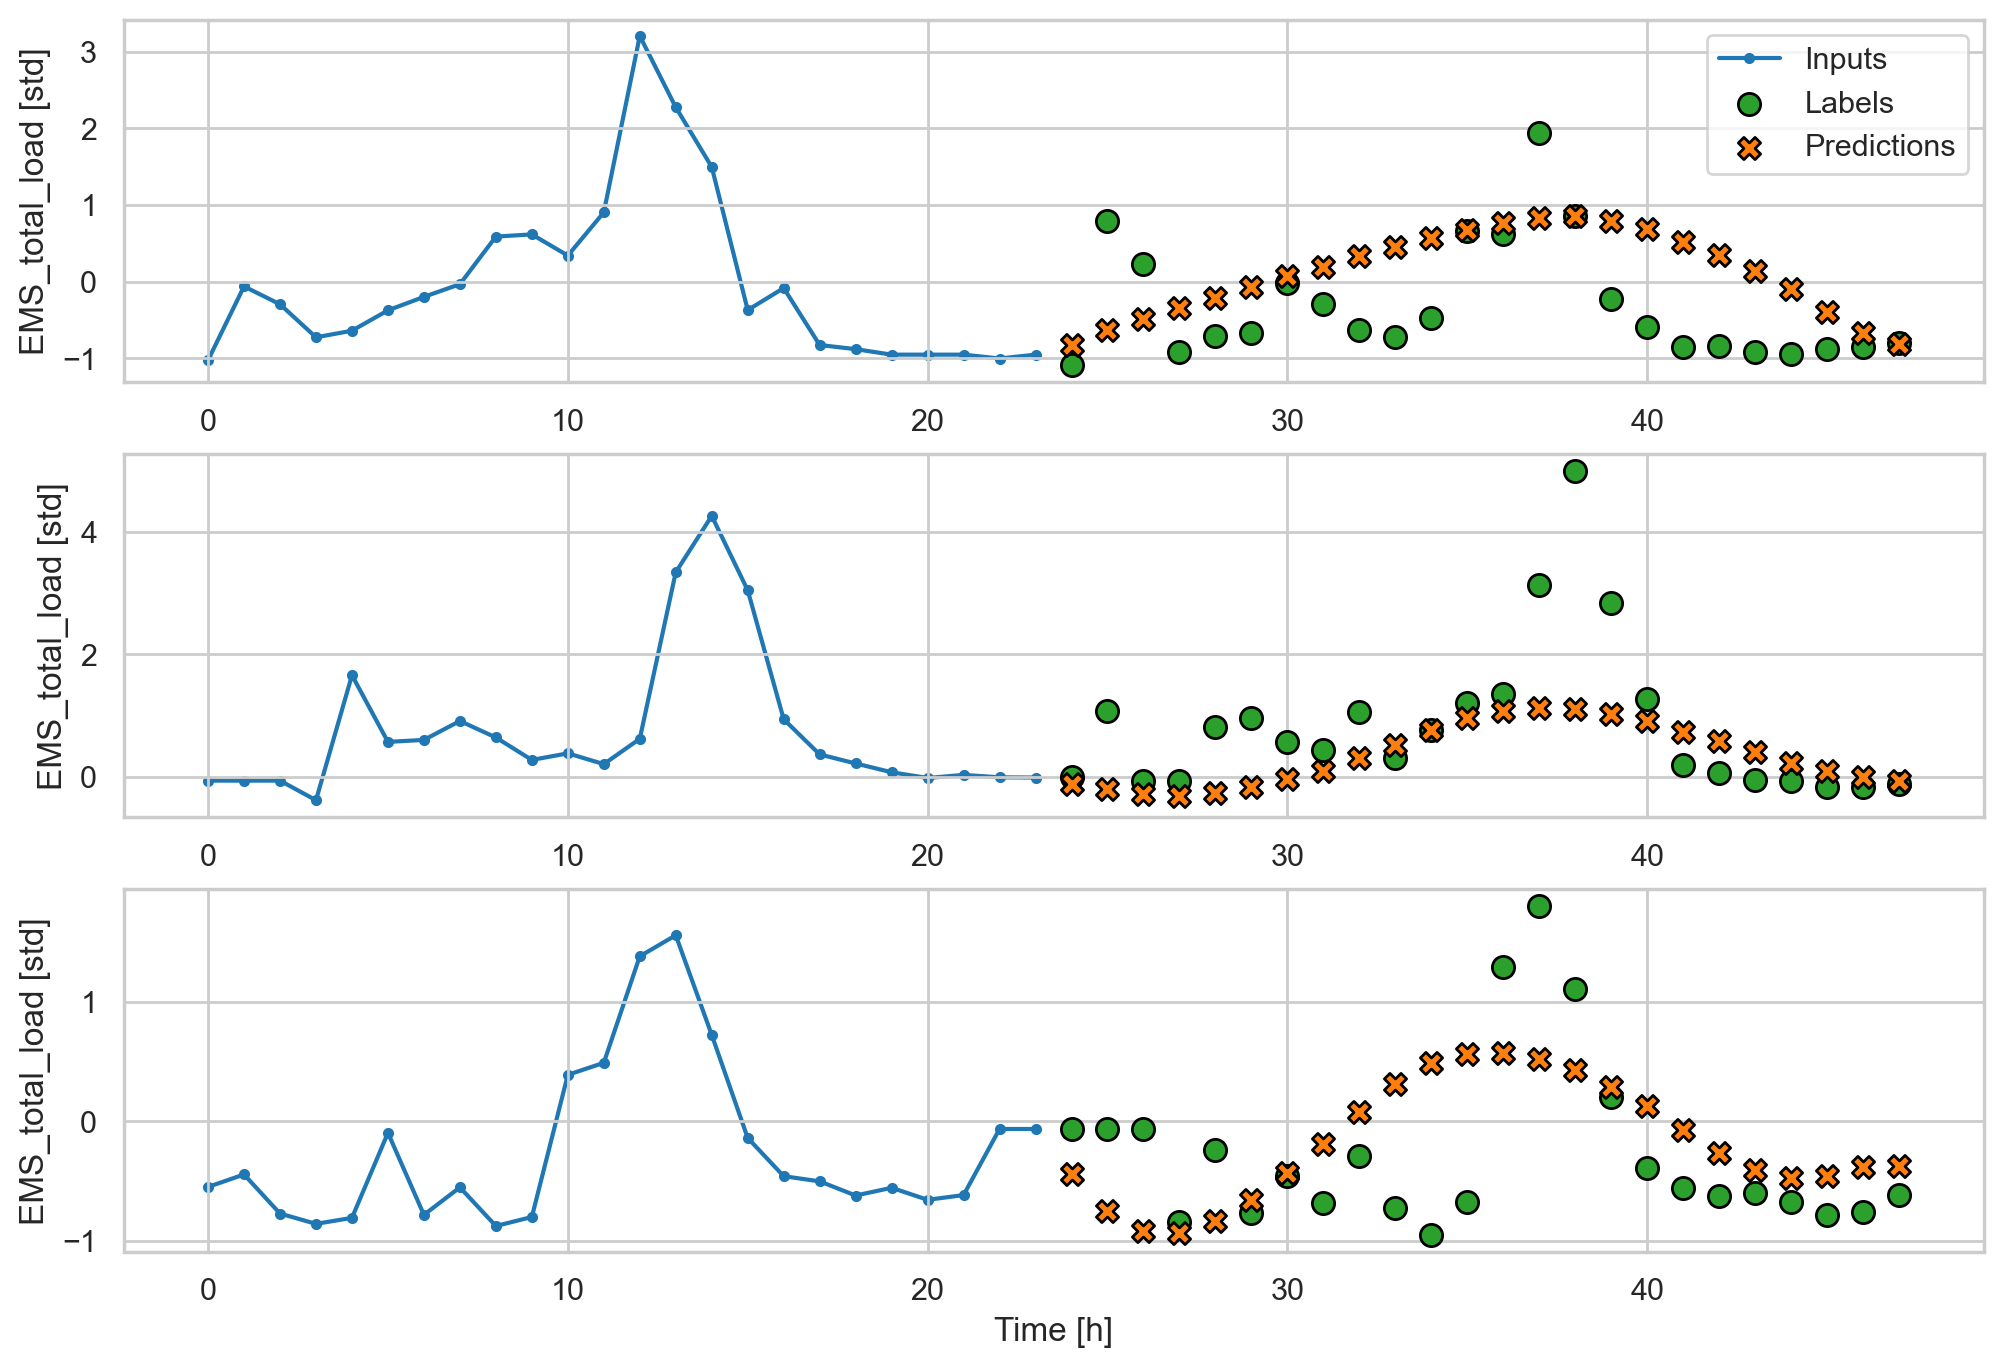

In [296]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    # tf.keras.layers.Reshape([OUT_STEPS, num_features])
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [297]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_linear_model(multi_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


## Dense

26/26 [==============================] - 0s 1ms/step - loss: 0.1656 - mean_absolute_error: 0.3170


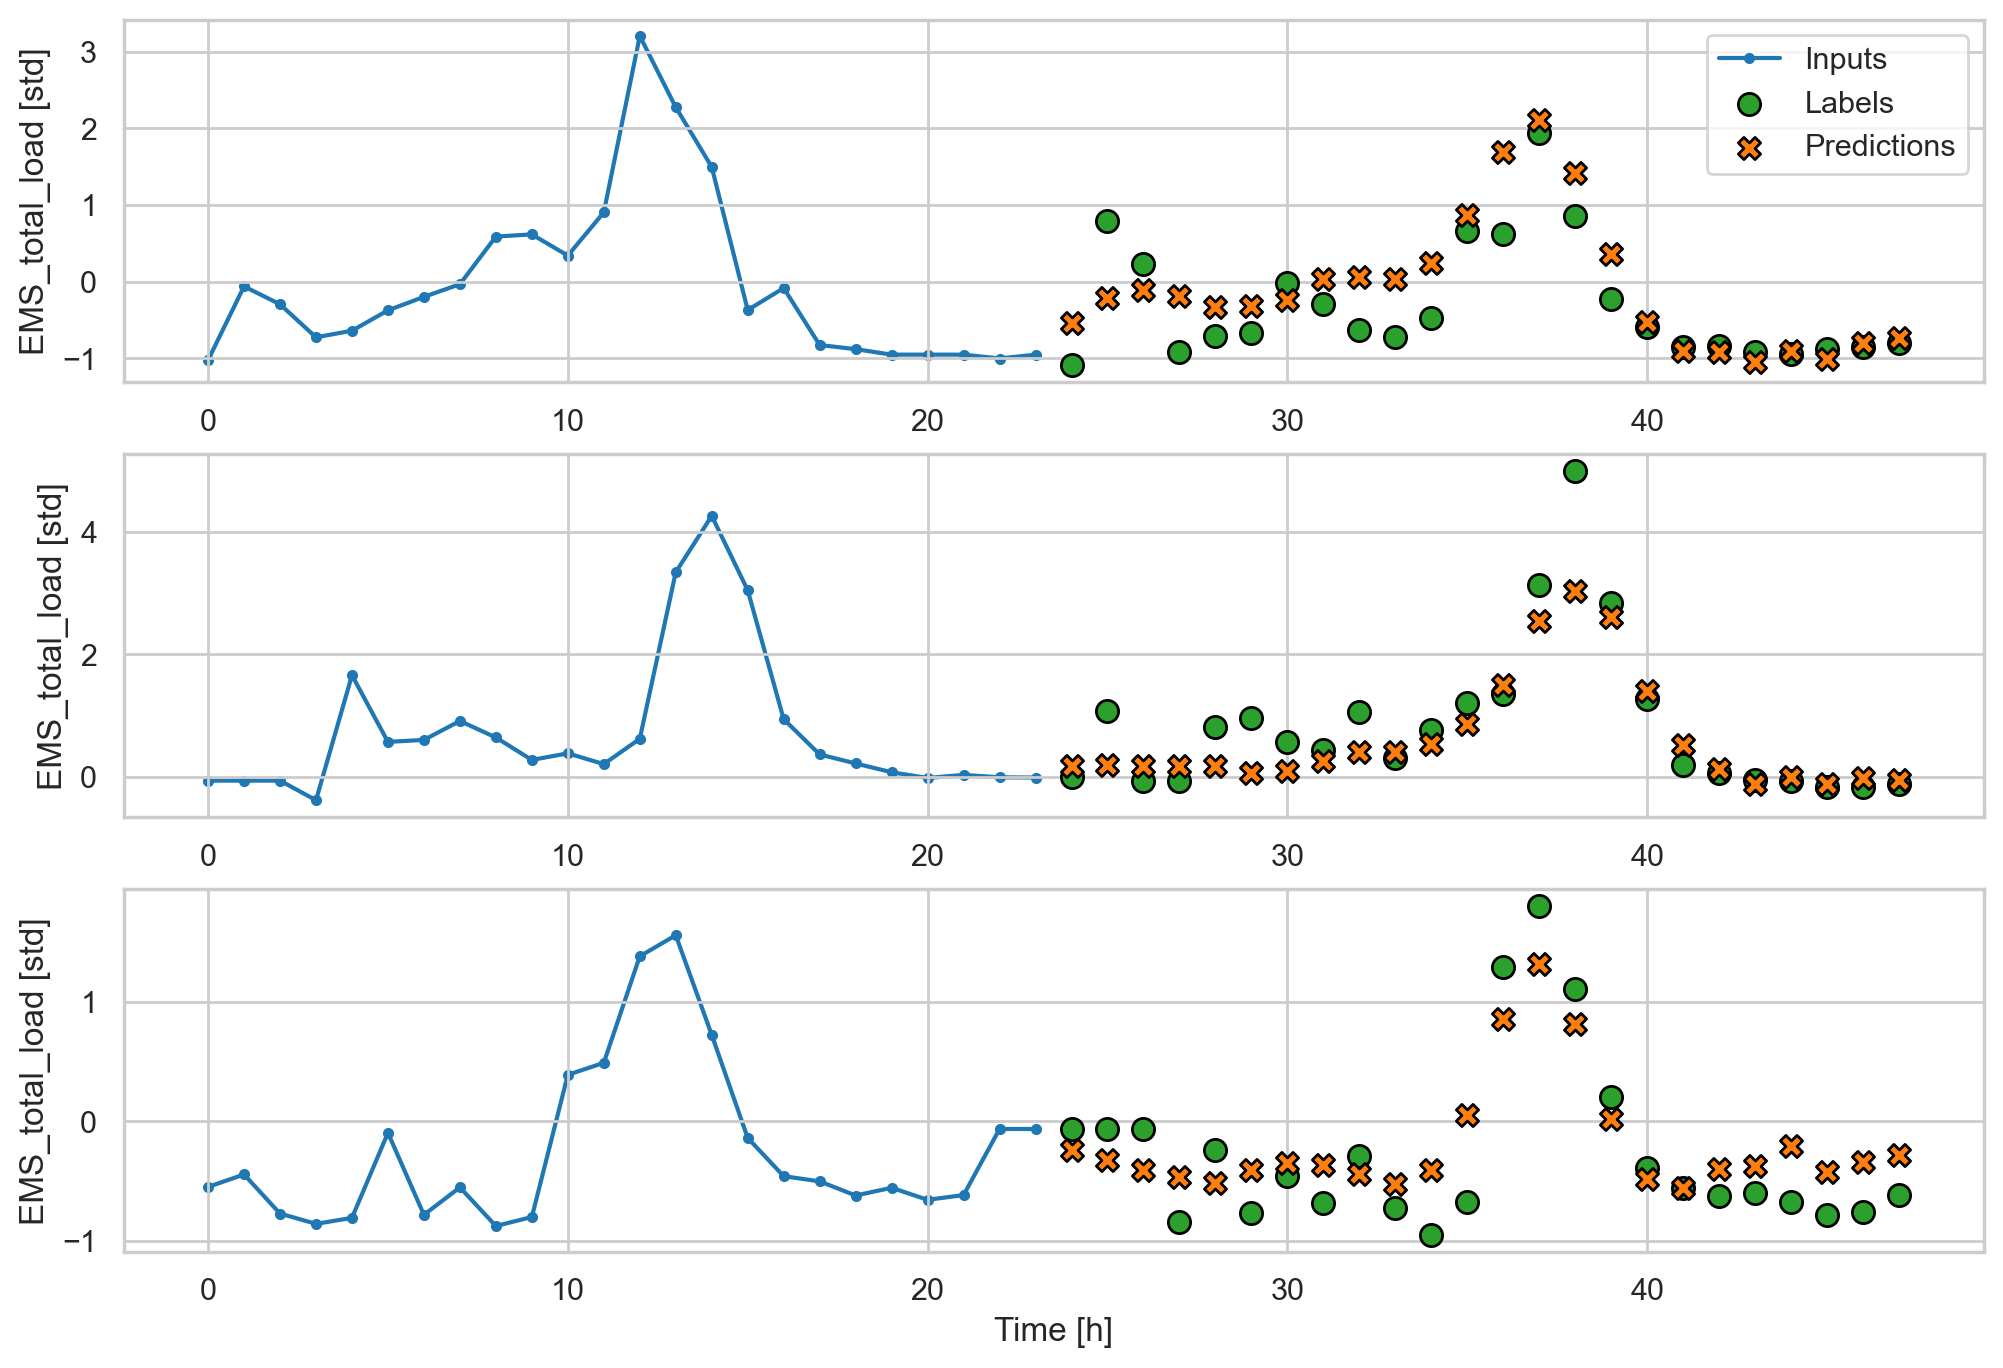

In [298]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

In [299]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_dense_model(multi_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


## CNN

26/26 [==============================] - 0s 1ms/step - loss: 0.1675 - mean_absolute_error: 0.3134


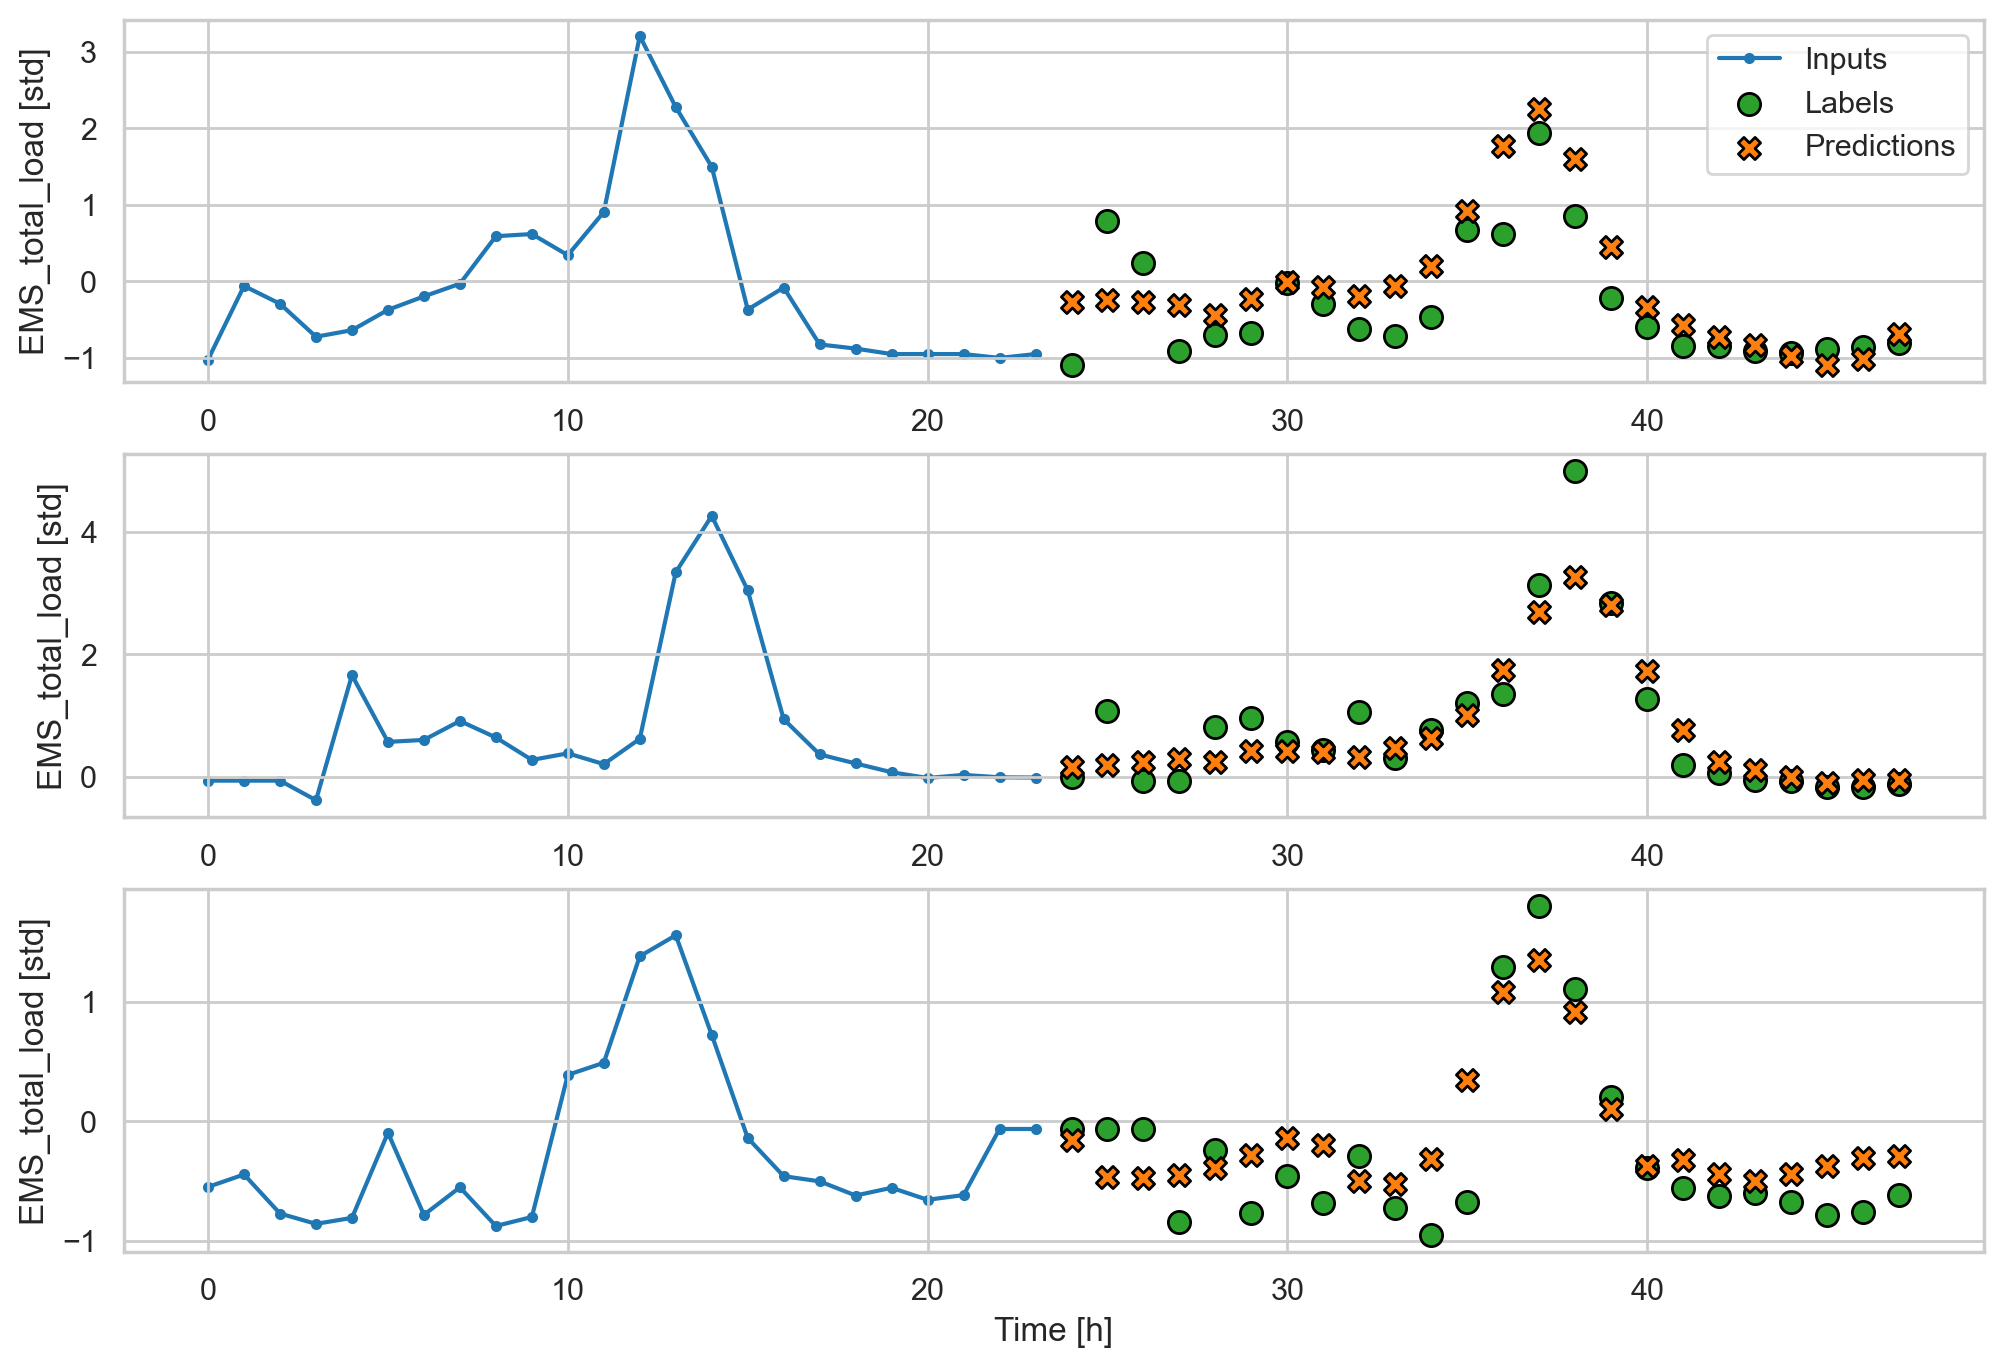

In [300]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [301]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_conv_model(multi_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


## RNN (LSTM)

26/26 [==============================] - 0s 2ms/step - loss: 0.1547 - mean_absolute_error: 0.2857


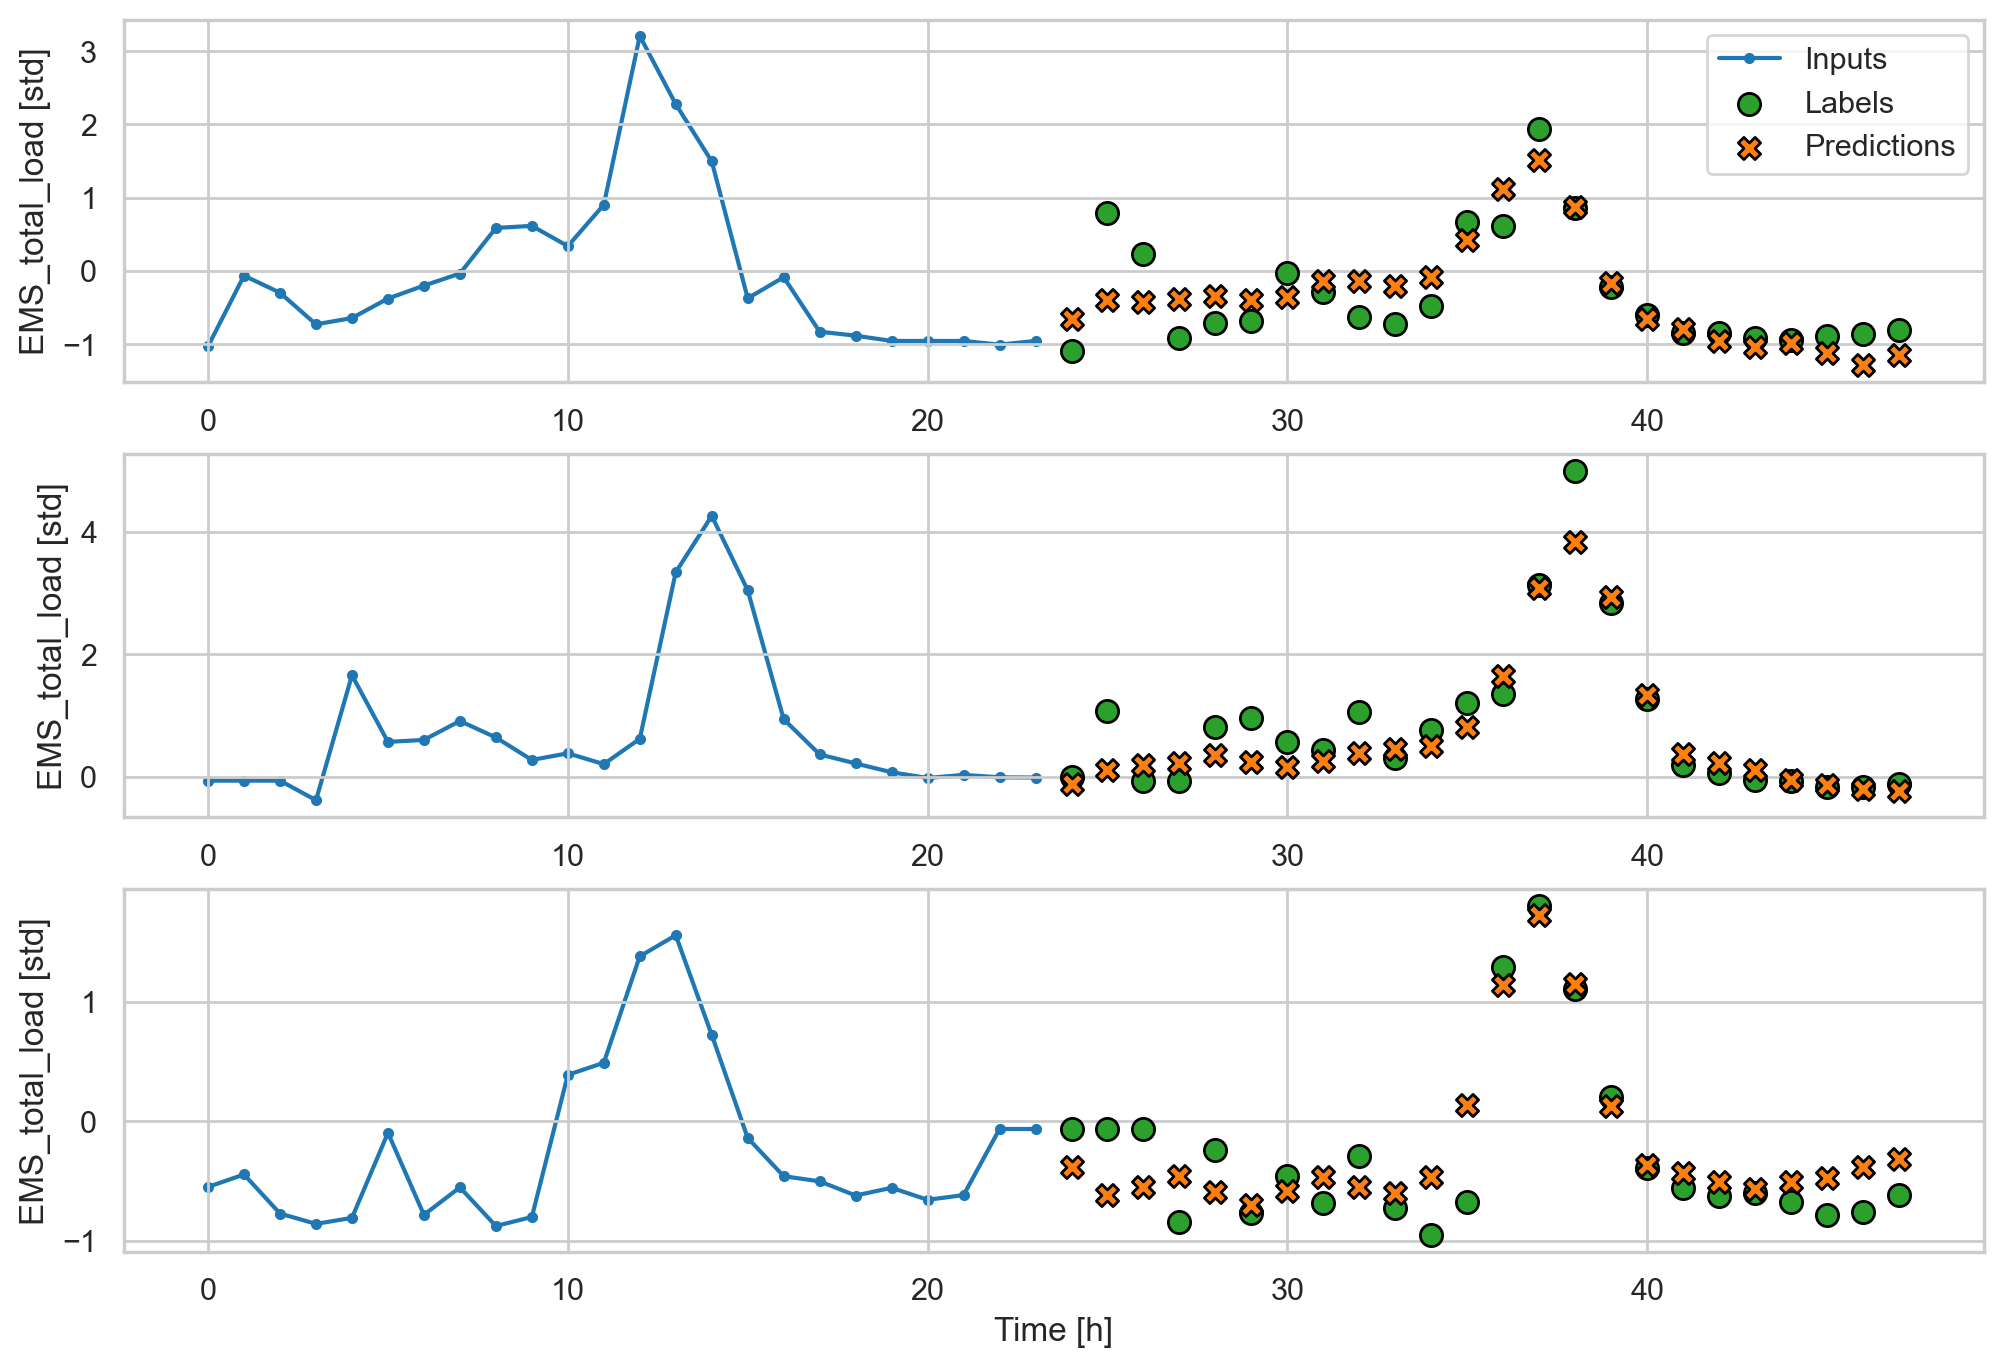

In [302]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [303]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape)

Input shape: (32, 24, 10)
Output shape: (32, 24, 1)


## Performance

Text(0.5, 1.0, 'Electrical Load')

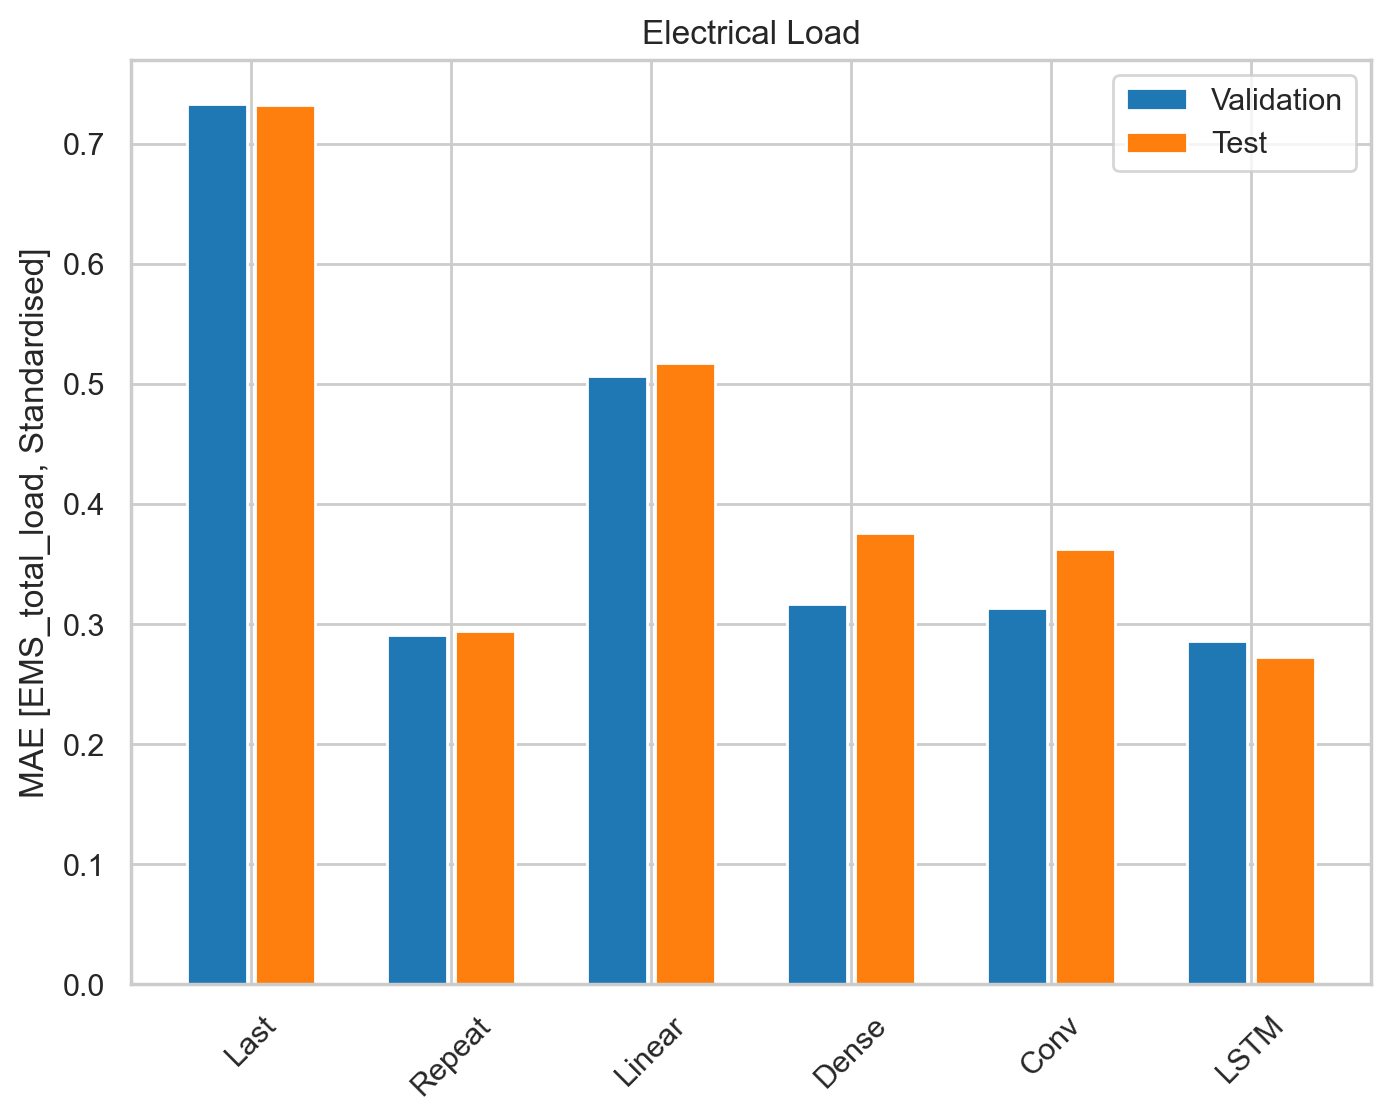

In [341]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE [EMS_total_load, Standardised]')
_ = plt.legend()
plt.title('Electrical Load')

In [305]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.7322
Repeat  : 0.2939
Linear  : 0.5177
Dense   : 0.3754
Conv    : 0.3629
LSTM    : 0.2724


## Predicting the next week of electrical load based the previous week using an LSTM Model

### Create Window for Training

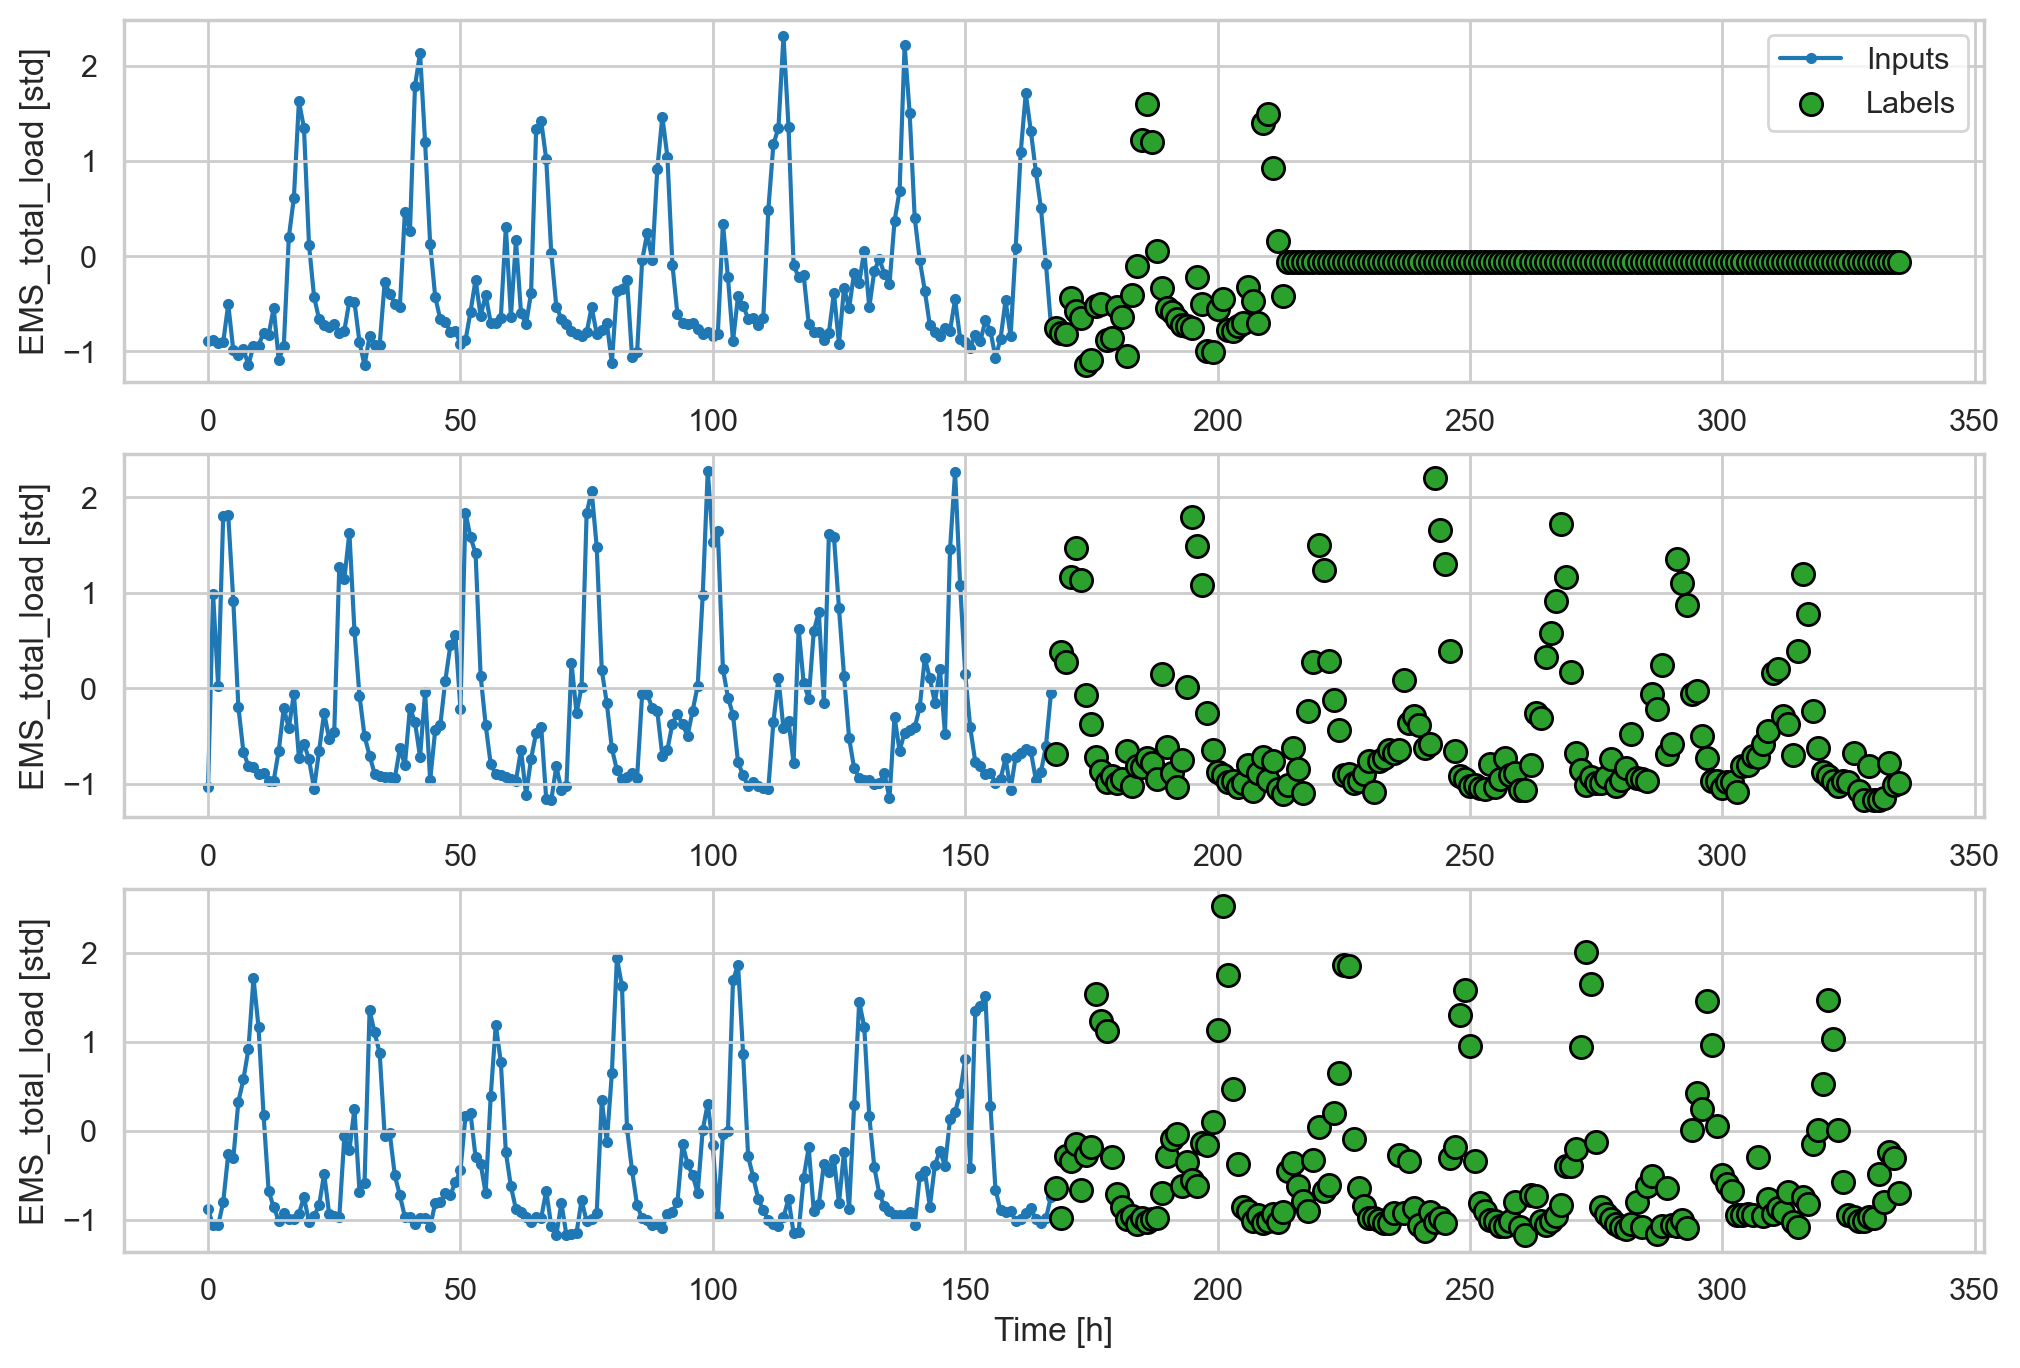

In [306]:
num_forecast_steps = 24 * 7 # 1 Week
long_window = WindowGenerator(input_width=num_forecast_steps,
                              label_width=num_forecast_steps,
                              shift=num_forecast_steps,
                              label_columns=['EMS_total_load'])

long_window.plot()

### Build and Train the model using the data windows

In [307]:
long_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(num_forecast_steps,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([num_forecast_steps, 1])
])

history = compile_and_fit(long_lstm_model, long_window)

IPython.display.clear_output()

print(long_lstm_model.evaluate(long_window.val))
print(long_lstm_model.evaluate(long_window.test, verbose=0))

17/17 [==============================] - 0s 16ms/step - loss: 0.1607 - mean_absolute_error: 0.3157
[0.16070958971977234, 0.3156798779964447]
[0.1553364247083664, 0.2990972697734833]


In [308]:
long_lstm_model.metrics_names

['loss', 'mean_absolute_error']

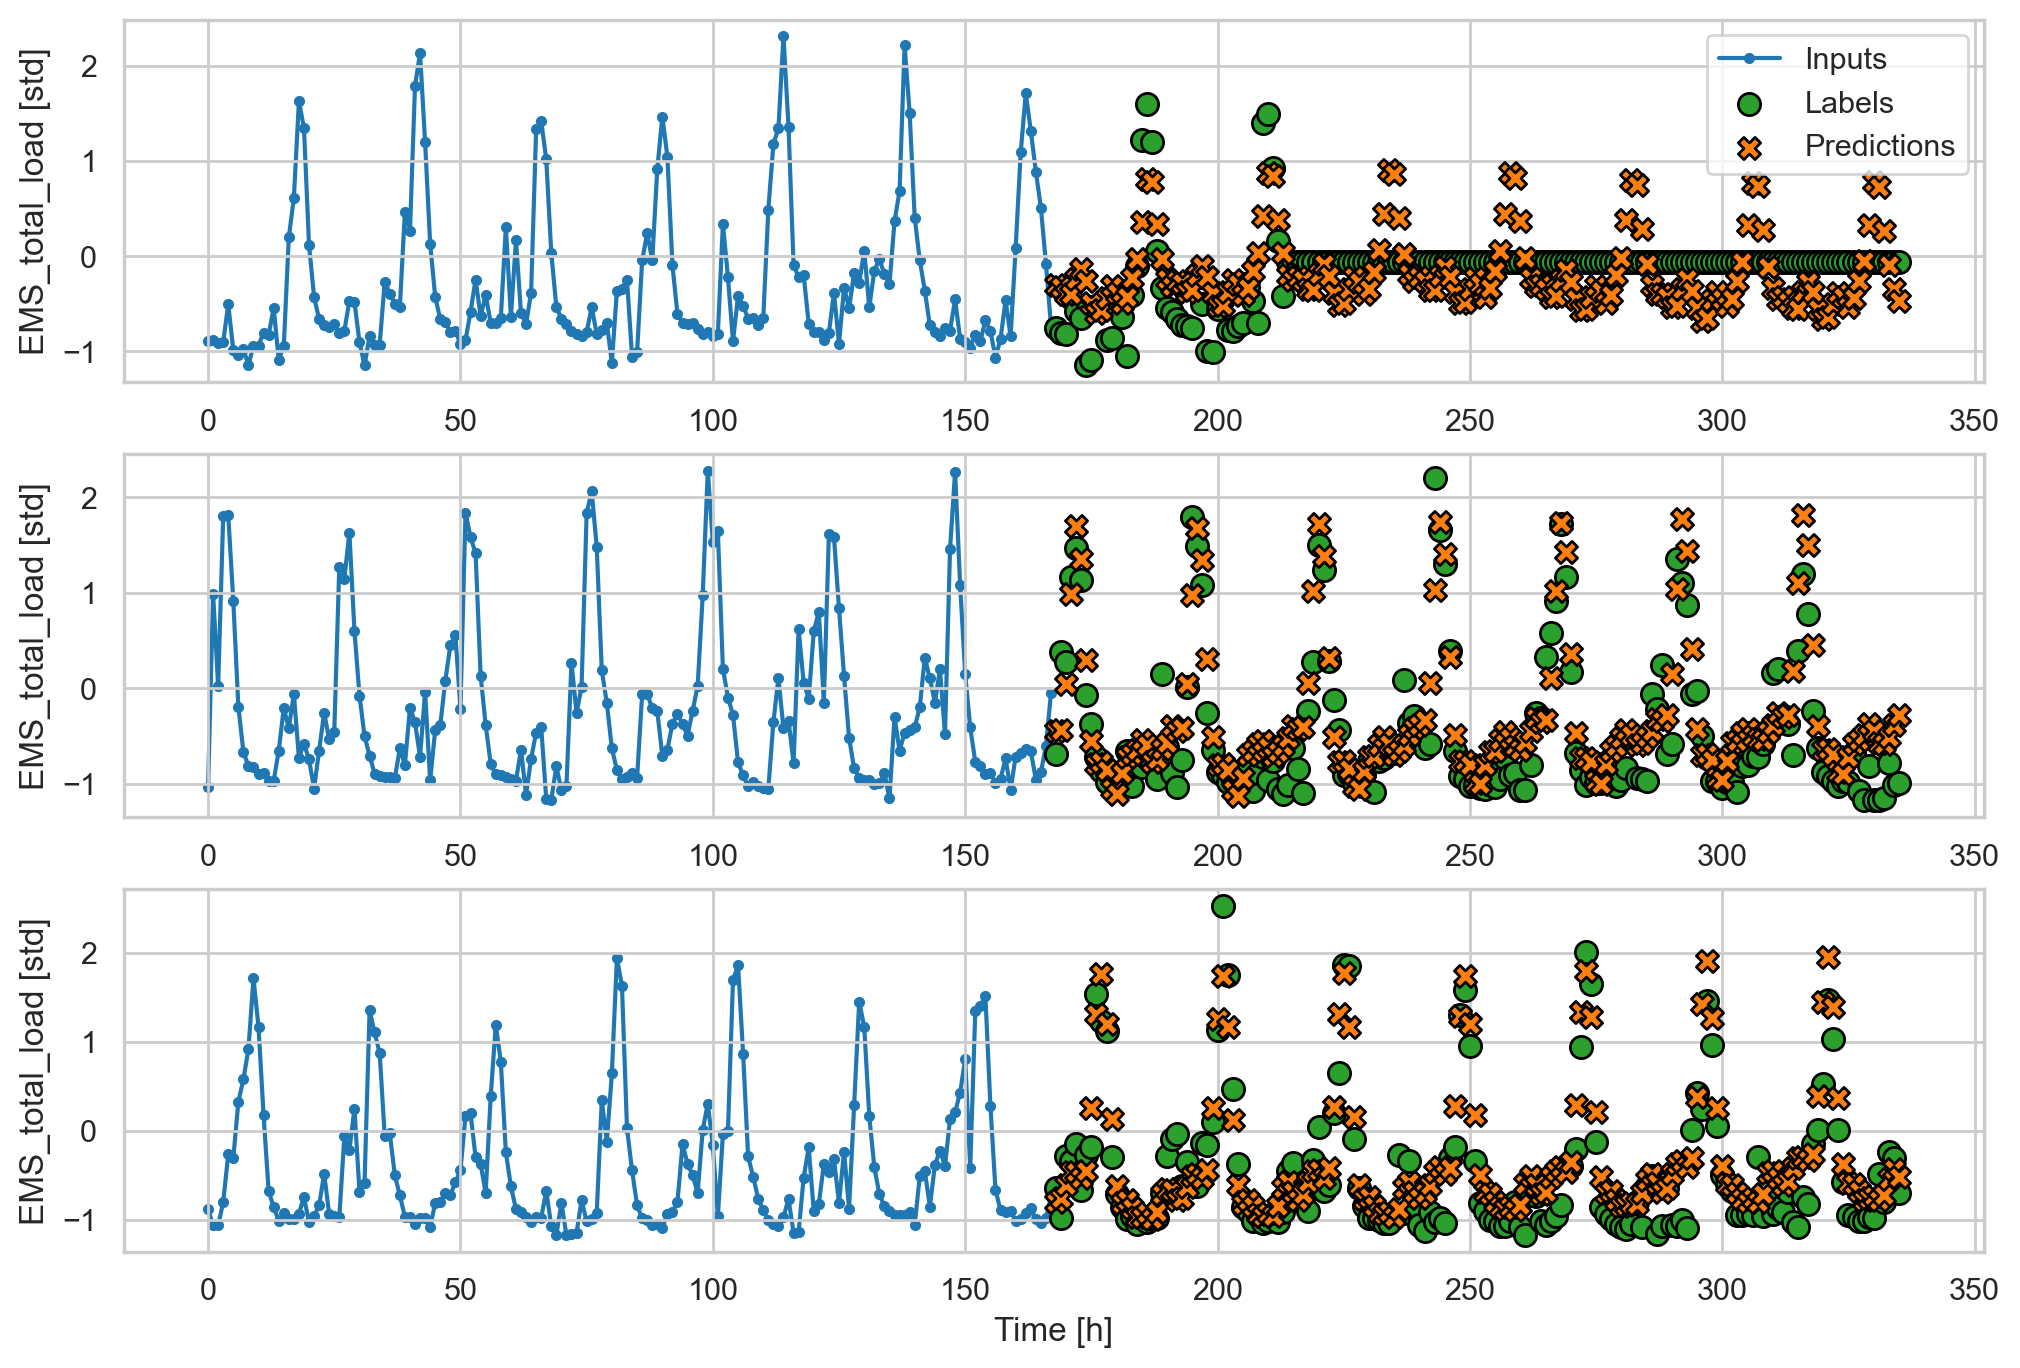

In [309]:
long_window.plot(long_lstm_model)

### Select input data (penultimate 1 week period)

#### Standardise Data

In [310]:
df_std = (df - train_mean) / train_std 
df_std

PrealL1   PrealL2   PrealL3  EMS_total_load       Day sin   Day cos  \
0     1.583411 -0.328781 -0.203540        1.053372 -8.550051e-12  1.414113   
1     1.244045 -0.696255 -0.203540        0.665388  3.659993e-01  1.365928   
2     1.253472 -0.604387 -0.300382        0.686943  7.070563e-01  1.224657   
3     1.130923 -0.645217 -0.358487        0.568392  9.999287e-01  0.999929   
4    -0.068367 -0.089002  0.103956       -0.064149  1.224657e+00  0.707056   
...        ...       ...       ...             ...           ...       ...   
8755  0.339069  0.630735  1.055407        0.676166 -1.365928e+00  0.365999   
8756  1.484429  1.569835  1.849513        2.026925 -1.224657e+00  0.707056   
8757  1.564557  2.366029  1.345934        2.274804 -9.999287e-01  0.999929   
8758  0.937673  0.640942  0.764881        1.082112 -7.070563e-01  1.224657   
8759  0.174099  0.283676  0.629302        0.349253 -3.659993e-01  1.365928   

      Week sin  Week cos  Year sin  Year cos  
0     1.103391  0.891812 -0.175054  1.810437  
1     1.135525  0.849776 -0.174053  1.810425  
2     1.166071  0.806563 -0.173052  1.810412  
3     1.194986  0.762234 -0.172050  1.810398  
4     1.222230  0.716851 -0.171049  1.810384  
...        ...       ...       ...       ...  
8755  1.410347 -0.044524 -0.185888  1.810520  
8756  1.407387 -0.097426 -0.184887  1.810516  
8757  1.402459 -0.150180 -0.183886  1.810512  
8758  1.395569 -0.202711 -0.182884  1.810506  
8759  1.386726 -0.254948 -0.181883  1.810500  

[8760 rows x 10 columns]

#### Filter Input Data

In [311]:
data = np.array(df_std[-2*num_forecast_steps:-num_forecast_steps], dtype=np.float32)
data

array([[-0.5753339 , -0.6656324 ,  0.06761788, ..., -0.30681598,
        -0.514352  ,  1.7690511 ],
       [-0.62246805, -0.624802  , -0.00985582, ..., -0.35824314,
        -0.5133779 ,  1.7693036 ],
       [-0.6366083 , -0.74729335, -0.02922424, ..., -0.40915743,
        -0.51240367,  1.7695552 ],
       ...,
       [ 2.2527163 ,  1.3860979 ,  1.3459338 , ..., -0.15017965,
        -0.35174897,  1.8003354 ],
       [ 1.2817523 ,  0.9267553 ,  0.82298636, ..., -0.20271145,
        -0.35075432,  1.8004609 ],
       [ 0.41448364,  0.35512894,  0.7648811 , ..., -0.2549479 ,
        -0.34975955,  1.8005857 ]], dtype=float32)

#### Convert Data into TensorFlow Dataset

In [312]:
ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      sequence_length=num_forecast_steps,
      targets=None)

#### Make Predictions

In [313]:
predictions = long_lstm_model.predict(ds)

1/1 [==============================] - 1s 676ms/step


In [314]:
predictions.shape

(1, 168, 1)

#### Un-standardise Predictions

In [315]:
for i in range(0, len(predictions[0])):
    predictions[0][i][0] = (predictions[0][i][0] * train_std.EMS_total_load) + train_mean.EMS_total_load

In [316]:
df

PrealL1      PrealL2      PrealL3  EMS_total_load       Day sin  \
0     6400.000000  1100.000000   400.000000     7900.000000 -6.012051e-12   
1     5680.000000   740.000000   400.000000     6820.000000  2.588190e-01   
2     5700.000000   830.000000   350.000000     6880.000000  5.000000e-01   
3     5440.000000   790.000000   320.000000     6550.000000  7.071068e-01   
4     2895.582321  1334.901958   558.761405     4789.245683  8.660254e-01   
...           ...          ...          ...             ...           ...   
8755  3760.000000  2040.000000  1050.000000     6850.000000 -9.659258e-01   
8756  6190.000000  2960.000000  1460.000000    10610.000000 -8.660254e-01   
8757  6360.000000  3740.000000  1200.000000    11300.000000 -7.071068e-01   
8758  5030.000000  2050.000000   900.000000     7980.000000 -5.000000e-01   
8759  3410.000000  1700.000000   830.000000     5940.000000 -2.588190e-01   

       Day cos  Week sin  Week cos  Year sin  Year cos  
0     1.000000  0.781831  0.623490  0.010881  0.999941  
1     0.965926  0.804598  0.593820  0.011597  0.999933  
2     0.866025  0.826239  0.563320  0.012314  0.999924  
3     0.707107  0.846724  0.532032  0.013031  0.999915  
4     0.500000  0.866025  0.500000  0.013747  0.999905  
...        ...       ...       ...       ...       ...  
8755  0.258819  0.999301 -0.037391  0.003125  0.999995  
8756  0.500000  0.997204 -0.074730  0.003842  0.999993  
8757  0.707107  0.993712 -0.111964  0.004559  0.999990  
8758  0.866025  0.988831 -0.149042  0.005275  0.999986  
8759  0.965926  0.982566 -0.185912  0.005992  0.999982  

[8760 rows x 10 columns]

#### Plot Results

Text(0.5, 1.0, 'Electricity demand forecast')

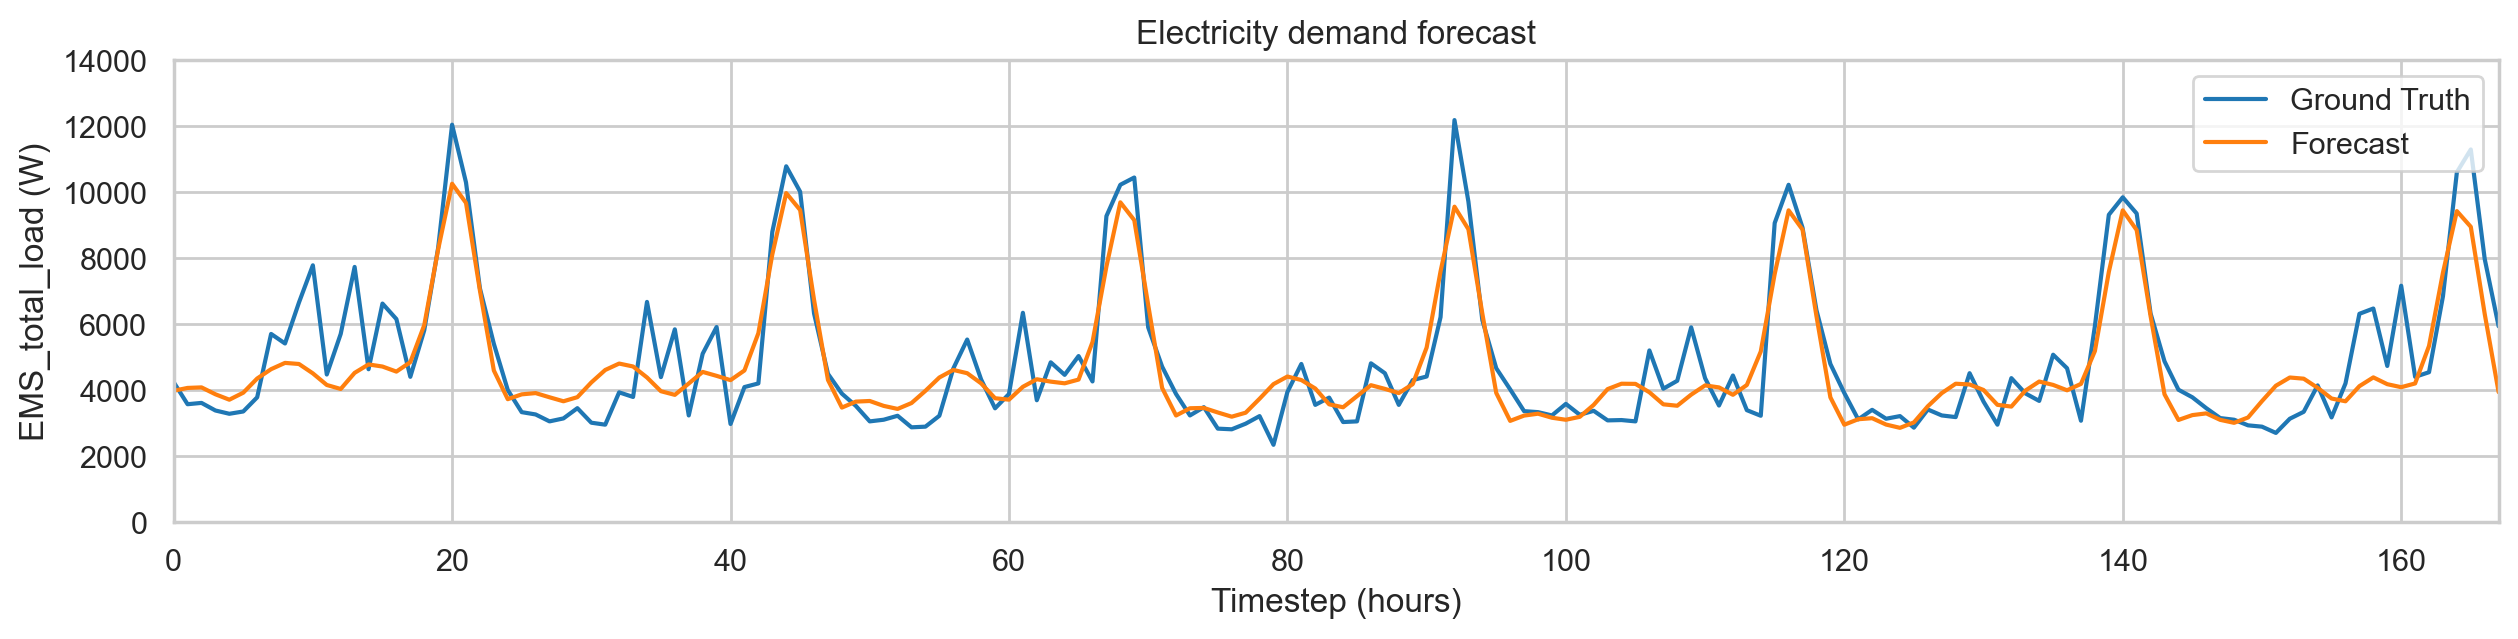

In [322]:
plt.figure(figsize=(15, 3))
plt.plot(df[-num_forecast_steps:].EMS_total_load.reset_index(drop=True), label='Ground Truth')
plt.plot(predictions[0], label='Forecast')
plt.xlim([0, len(predictions[0]) - 1])
plt.ylim([0, 14000])
plt.xlabel('Timestep (hours)')
plt.ylabel('EMS_total_load (W)')
plt.legend()
plt.title('Electricity demand forecast')

#### Calculate Mean Absolute Error

In [318]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df[-num_forecast_steps:].EMS_total_load, predictions[0])

785.9514807645606